In [1]:
import jax, numpyro
import jax.numpy as jnp
from jax import config
config.update('jax_platform_name', 'cpu')
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')

In [2]:
import numpy as np
import pandas as pd
from jax import random
from jaxspec.specfit import SpecFit
from jaxspec.infer import *
import glob, pathlib, dill, corner

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'

## load sample data
- This part should be changed according to the data you have
- We need: wav_obs, flux_obs, error_obs, mask_obs; all have the same shapes of (number of orders) x (number of pixels in each order)
- mask_obs: if True the data point is masked

In [4]:
def load_ird_spectrum(datapath, orders):
    orders = np.atleast_1d(orders)
    data = pd.read_csv(datapath)
    wav_obs = np.array(data.lam).reshape(-1,2048)[orders,:] * 10 # nm -> AA
    flux_obs = np.array(data.normed_flux).reshape(-1,2048)[orders,:]
    error_obs = np.array(data.flux_error).reshape(-1,2048)[orders,:]
    mask_obs = np.array(data.all_mask).reshape(-1,2048)[orders,:]
    return [wav_obs, flux_obs, error_obs, mask_obs]

In [5]:
datapath = "../data/IRDA00042313_H.csv"
orders = [8,9]
orders = [7,8,9,10,11]
orders += [13,14,15,17,18]

In [6]:
wav_obs, flux_obs, error_obs, mask_obs = load_ird_spectrum(datapath, orders)

In [7]:
# (number of orders) x (number of pixels in each order)
print (np.shape(wav_obs))

(10, 2048)


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_23733/294539435.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("wavelength ($\mathrm{\AA}$)")


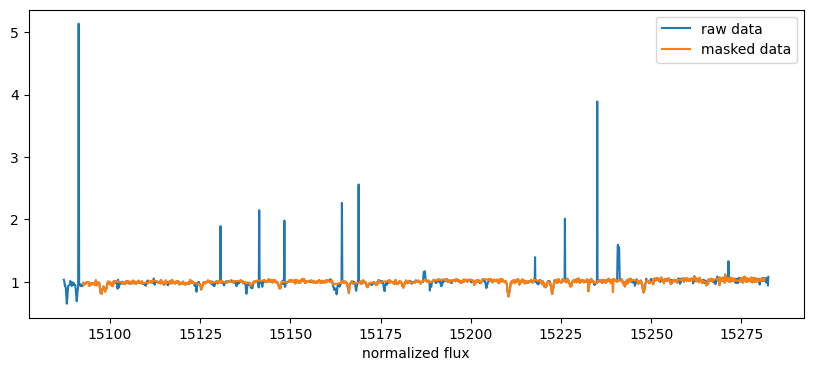

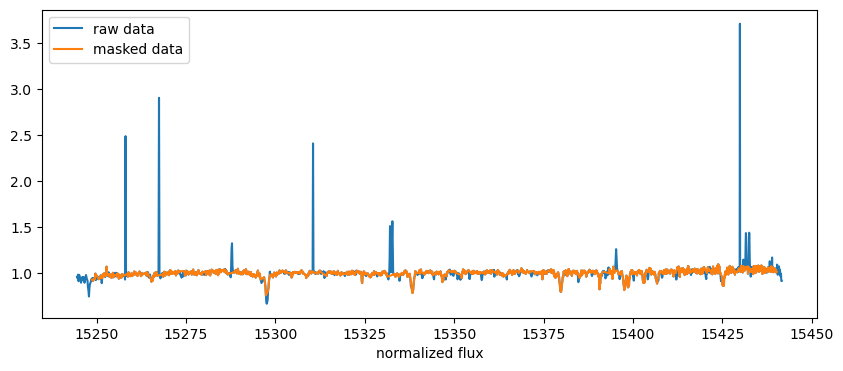

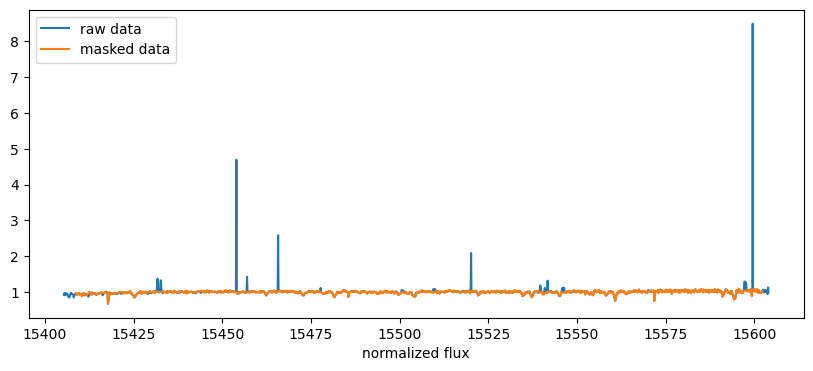

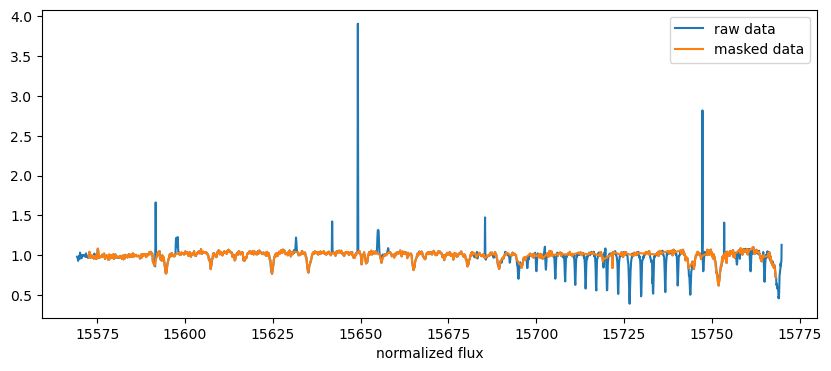

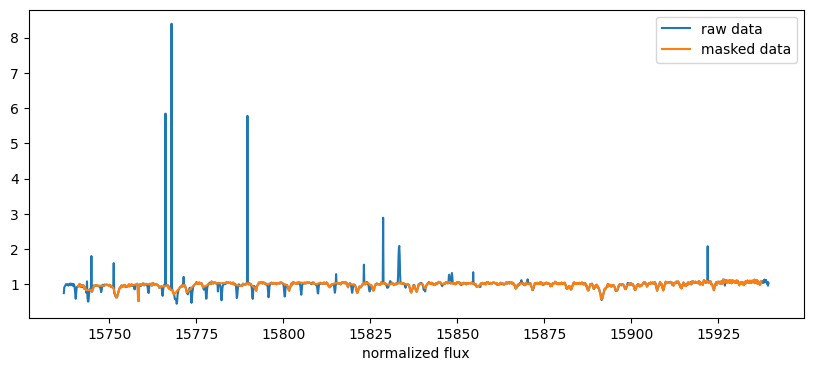

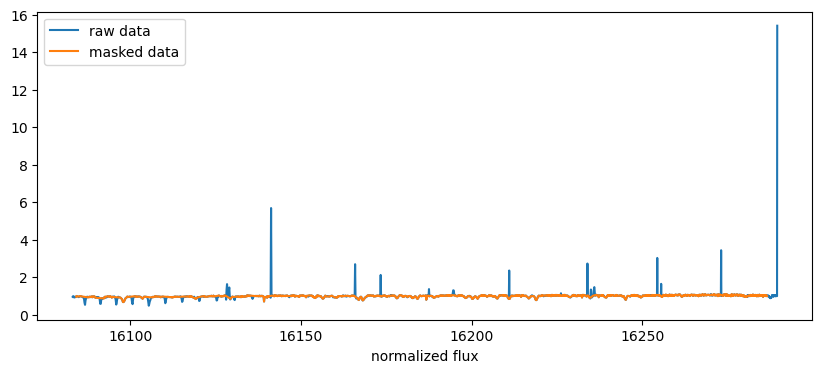

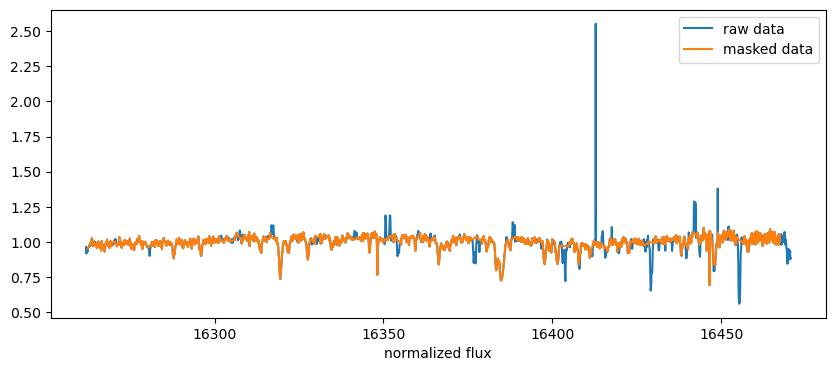

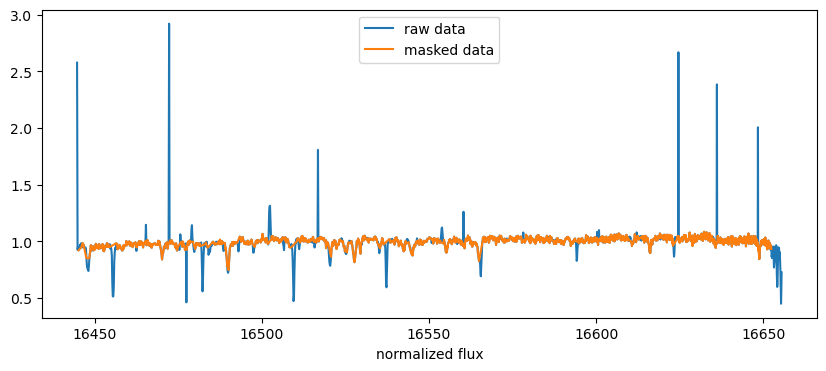

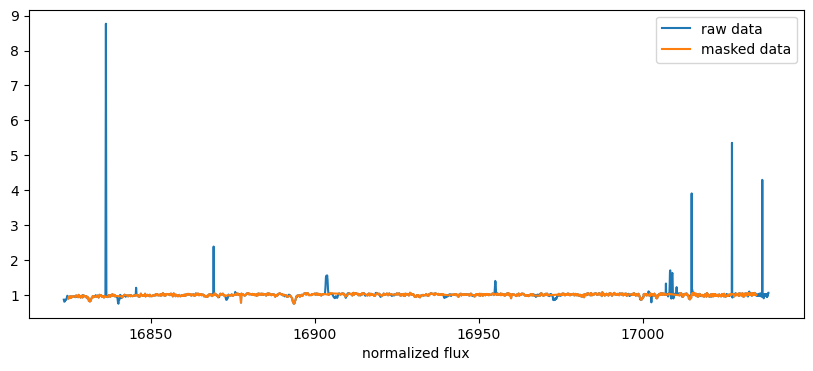

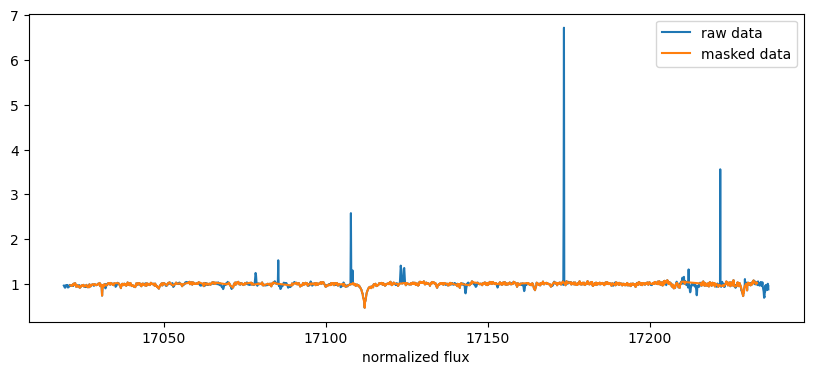

In [8]:
for j in range(len(orders)):
    clip = ~mask_obs[j]
    plt.figure()
    plt.xlabel("wavelength ($\mathrm{\AA}$)")
    plt.xlabel("normalized flux")
    plt.plot(wav_obs[j], flux_obs[j], label='raw data')
    plt.plot(wav_obs[j][clip], flux_obs[j][clip], label='masked data')
    plt.legend(loc='best')

## path to the spectrum grid 
- here we use the output of compute_coelho_grid.py

In [9]:
gridpath = "/Users/k_masuda/data/specgrid_irdh_turbospectrum3500"
#gridpath = "/Users/k_masuda/data/specgrid_irdh_coelho"

## specfit class

In [10]:
sf = SpecFit(gridpath, [wav_obs, flux_obs, error_obs, mask_obs], orders, vmax=50., wav_margin=3.)

In [11]:
# set fixed wavelength resolution
wavres = np.array([70000]*len(orders))
sf.add_wavresinfo(wavres, wavres)

## check cross correlation function

# order 7
# order 8
# order 9
# order 10
# order 11
# order 13
# order 14
# order 15
# order 17
# order 18


(-23.295981036574826, 25.042504250425054)

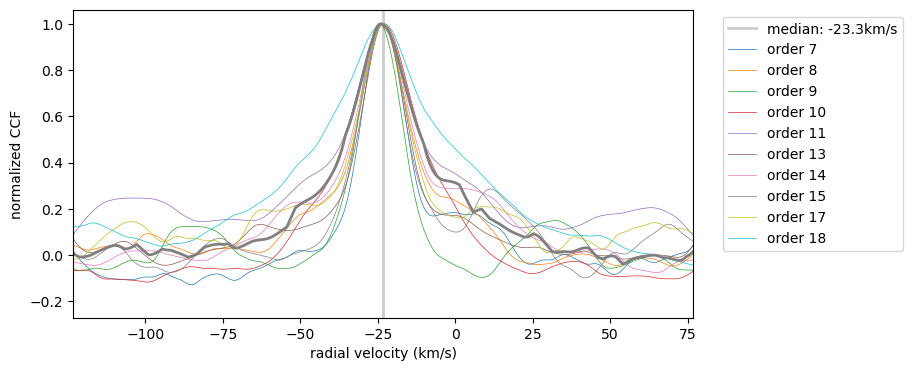

In [12]:
sf.check_ccf()

In [13]:
import numpyro.distributions as dist
import celerite2
from celerite2.jax import terms as jax_terms
from numpyro.infer import init_to_value

def model(sf, param_bounds, empirical_vmacro=False, lnsigma_max=-3, single_wavres=False, zeta_max=10., slope_max=0.2, lnc_max=2., logg_min=3., fit_dilution=False, physical_logg_max=False, save_pred=False):
    """ standard model
    """
    _sm = sf.sm
    par = {}

    for key in param_bounds.keys():
        if key=='logg' and physical_logg_max:
            continue
        if key=='zeta' and empirical_vmacro:
            continue
        if key=='wavres':
            continue
        par[key+"_scaled"] = numpyro.sample(key+"_scaled", dist.Uniform(jnp.zeros_like(param_bounds[key][0]), jnp.ones_like(param_bounds[key][0])))
        par[key] = numpyro.deterministic(key, par[key+"_scaled"] * (param_bounds[key][1] - param_bounds[key][0]) + param_bounds[key][0])

    if physical_logg_max:
        logg_max = -2.34638497e-08*par["teff"]**2 + 1.58069918e-04*par["teff"] + 4.53251890 # valid for 4500-7000K
        par["logg"] = numpyro.sample("logg", dist.Uniform(param_bounds["logg"][0], logg_max))
 
    if empirical_vmacro:
        zeta = numpyro.deterministic("zeta", 3.98 + (par["teff"] - 5770.) / 650.)
    
    par['u1'] = numpyro.deterministic("u1", 2*jnp.sqrt(par["q1"])*par["q2"])
    par['u2'] = numpyro.deterministic("u2", jnp.sqrt(par["q1"])-par["u1"])

    ones = jnp.ones(_sm.Norder)
    # wavres_min = wavres_max
    if param_bounds['wavres'][0][0] == param_bounds['wavres'][1][0]:
        par['wavres'] = numpyro.deterministic("wavres", param_bounds['wavres'][0])
    # wavres_min != wavres_max, order-independent wavres
    elif single_wavres:
        wavres_single = numpyro.sample("wavres", dist.Uniform(low=param_bounds['wavres'][0][0], high=param_bounds['wavres'][1][0]))
        par['wavres'] = ones * wavres_single
    # wavres_min != wavres_max, order-dependent wavres
    else:
        par['wavres'] = numpyro.sample("wavres", dist.Uniform(low=param_bounds['wavres'][0], high=param_bounds['wavres'][1])) 

    # dilution
    if fit_dilution:
        par['dilution'] = numpyro.sample("dilution", dist.Uniform())
    else:
        par['dilution'] = numpyro.deterministic("dilution", par['teff']*0.)

    fluxmodel = numpyro.deterministic("fluxmodel", _sm.fluxmodel_multiorder(par))

    lna = numpyro.sample("lna", dist.Uniform(low=-5, high=-0.5))
    lnc = numpyro.sample("lnc", dist.Uniform(low=-5, high=lnc_max))
    kernel = jax_terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnc))
    lnsigma = numpyro.sample("lnsigma", dist.Uniform(low=-10, high=lnsigma_max))
    diags = _sm.error_obs**2 + jnp.exp(2*lnsigma)

    mask_all = _sm.mask_obs + (_sm.mask_fit > 0)
    idx = ~mask_all
    for j in range(len(fluxmodel)):
        idxj = idx[j]
        gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
        gp.compute(_sm.wav_obs[j][idxj], diag=diags[j][idxj])
        flux_residual = numpyro.deterministic("flux_residual%d"%j, _sm.flux_obs[j][idxj] - fluxmodel[j][idxj])
        numpyro.sample("obs%d"%j, gp.numpyro_dist(), obs=flux_residual)
        if save_pred:
            numpyro.deterministic("pred%d"%j, gp.predict(flux_residual, t=_sm.wav_obs[j]))

In [14]:
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoMultivariateNormal
from numpyro.infer.initialization import init_to_value, init_to_sample

def optim_svi_mv(numpyro_model, step_size, num_steps, p_initial=None, **kwargs):
    """optimization using Stochastic Variational Inference (SVI)

        Args:
            numpyro_model: numpyro model
            step_size: step size for optimization
            num_steps: # of steps for optimization
            p_initial: initial parameter set (dict); if None, use init_to_sample to initialize

        Returns:
            p_fit: optimized parameter set

    """
    optimizer = numpyro.optim.Adam(step_size=step_size)
    
    if p_initial is None:
        guide = AutoMultivariateNormal(numpyro_model, init_loc_fn=init_to_sample)
    else:
        guide = AutoMultivariateNormal(numpyro_model, init_loc_fn=init_to_value(values=p_initial))

    # SVI object
    svi = SVI(numpyro_model, guide, optimizer, loss=Trace_ELBO(), **kwargs)

    # run the optimizer and get the posterior median
    svi_result = svi.run(random.PRNGKey(0), num_steps)
    params_svi = svi_result.params
    p_fit = guide.median(params_svi)

    posterior = guide.get_posterior(params_svi)
    covariance_matrix = posterior.covariance_matrix

    return p_fit, covariance_matrix

In [15]:
param_bounds = get_parameter_bounds(sf)

In [16]:
p_fit = optim_svi(model, 1e-2, 5000, sf=sf, param_bounds=param_bounds) # 3000 seems sufficient; 8218 -> 8412 (8,9)

  0%|          | 0/5000 [00:00<?, ?it/s]2024-11-10 22:58:12.992110: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_body_fn] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
2024-11-10 22:58:24.693947: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 21.704089s

********************************
[Compiling module jit_body_fn] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
100%|██████████| 5000/5000 [04:47<00:00, 17.37it/s, init loss: -15639.1617, avg. loss [4751-5000]: -37774.6265]


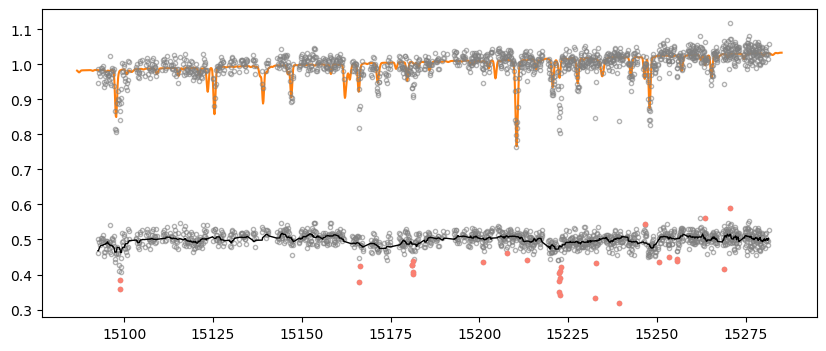

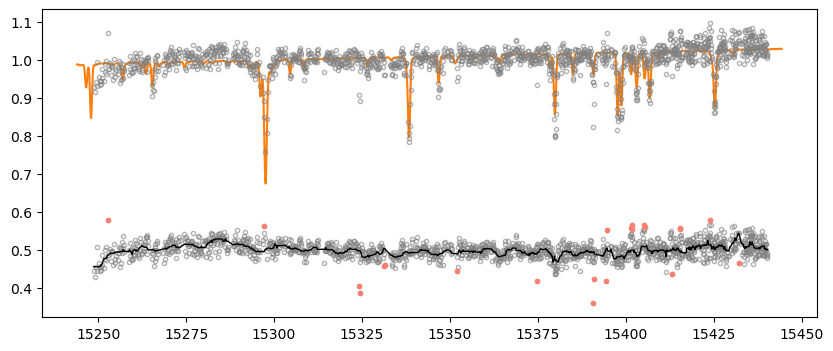

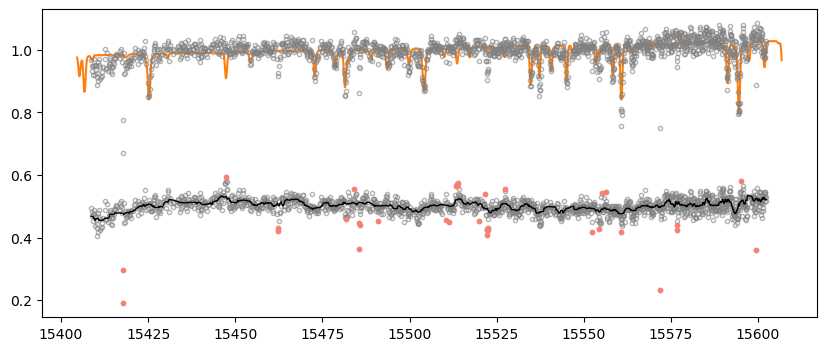

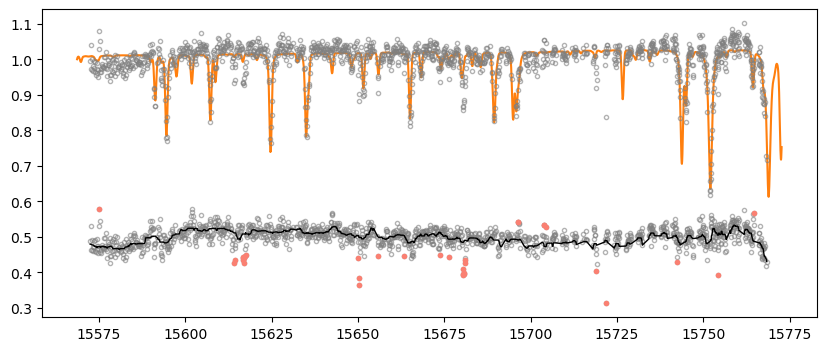

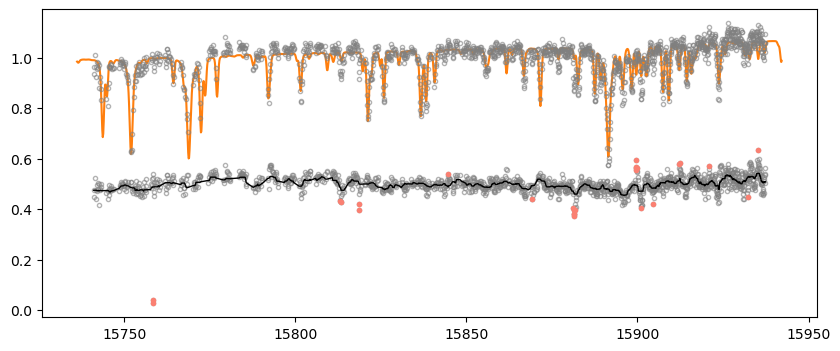

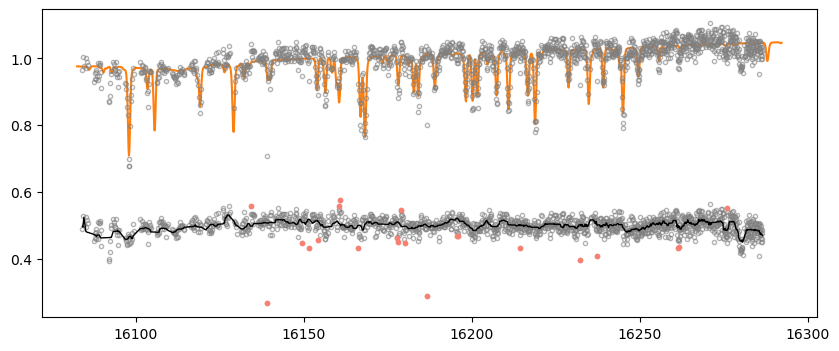

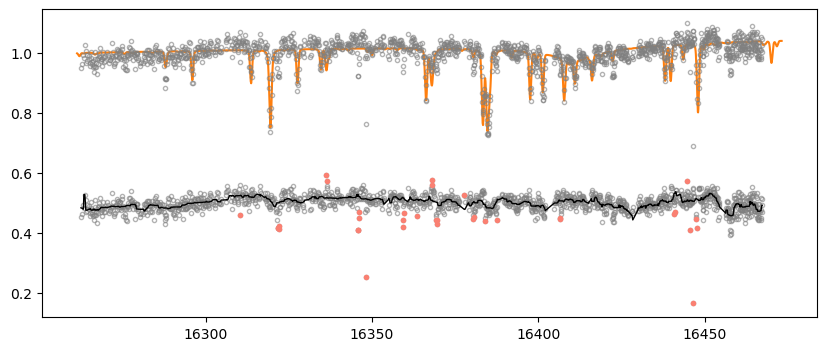

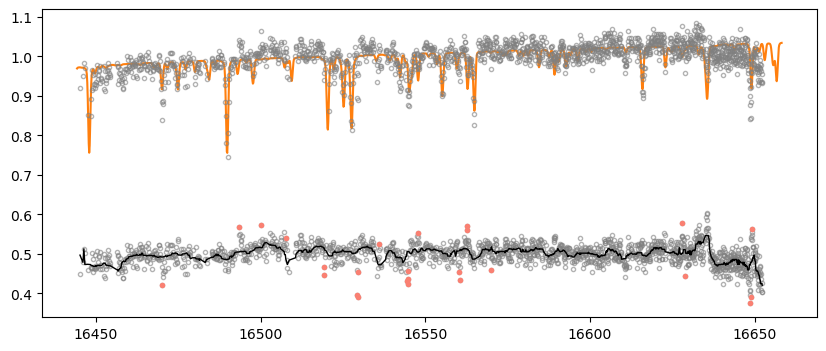

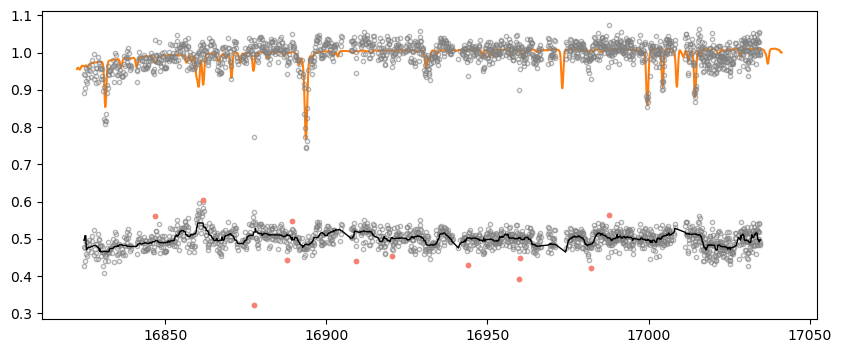

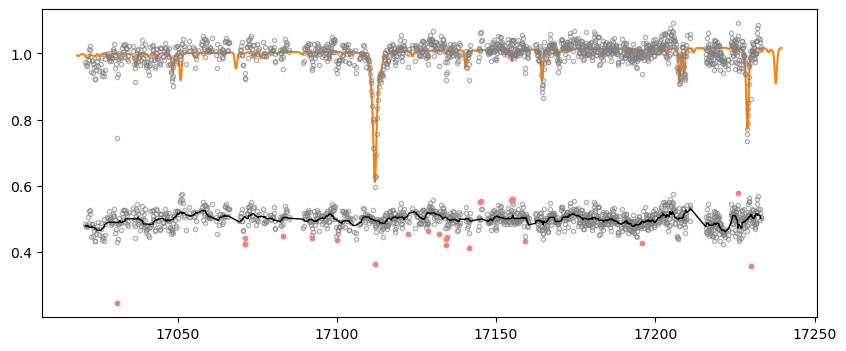

In [17]:
sf.mask_outliers(p_fit, plot=True, sigma_threshold=3.)

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/envs/jax4/lib/python3.12/site-packages/jaxspec-0.1.0-py3.12.egg/jaxspec/specfit.py:380: RuntimeWarning: invalid value encountered in divide
  residuals = np.array(sm.flux_obs - ms) / self.sm.error_obs


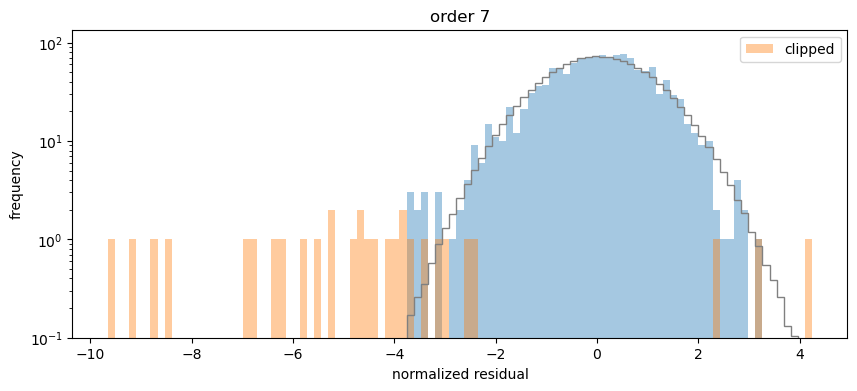

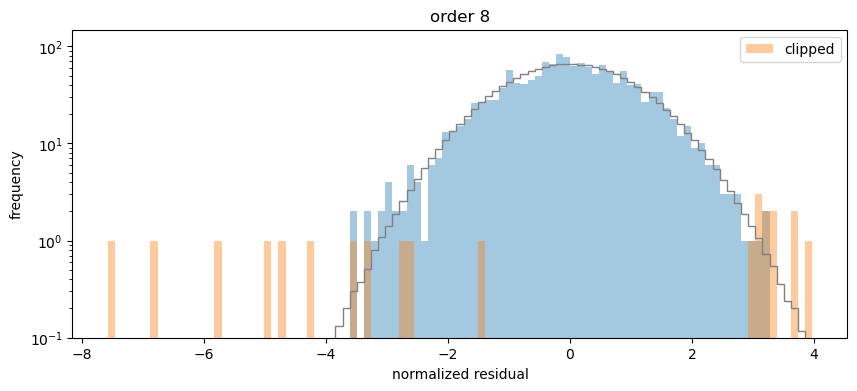

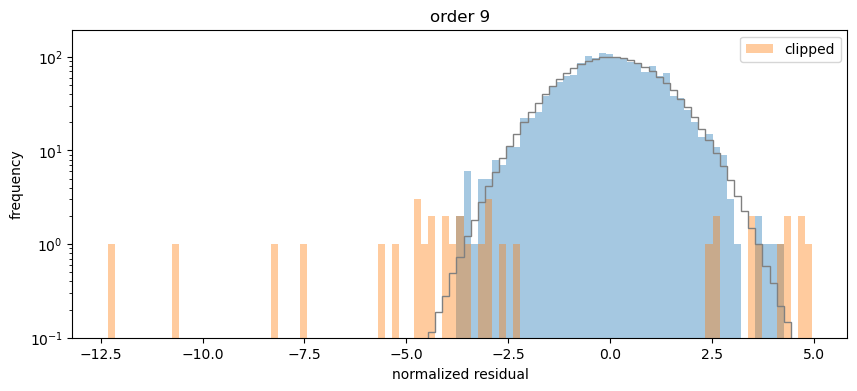

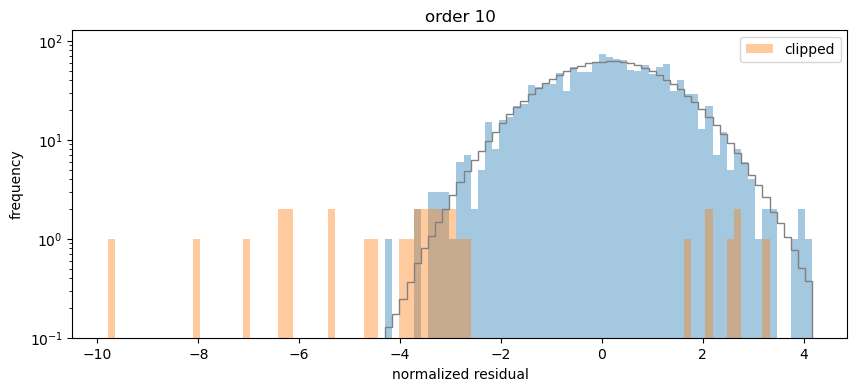

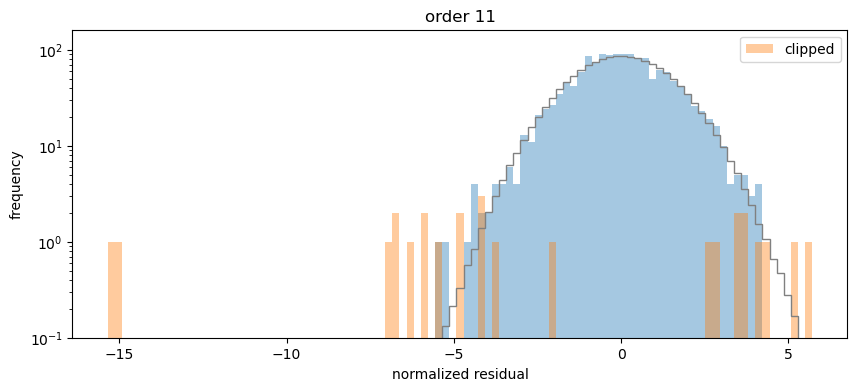

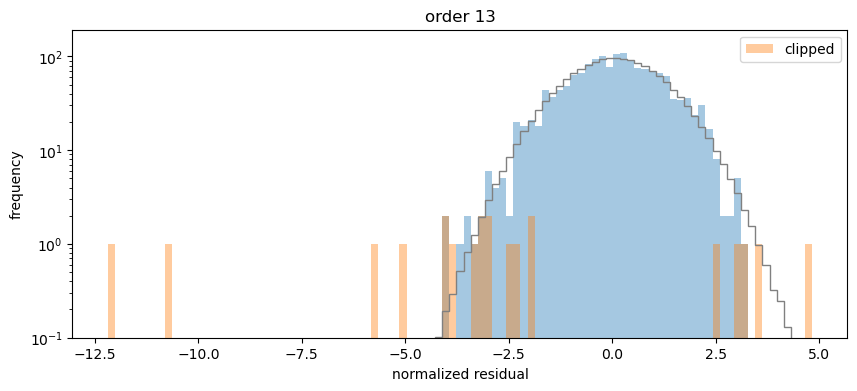

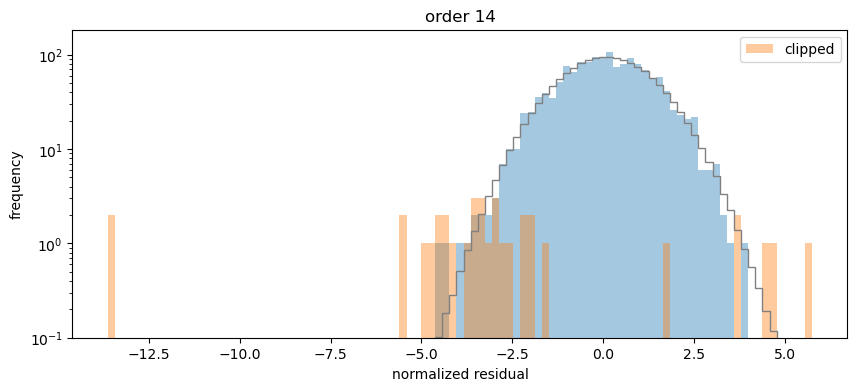

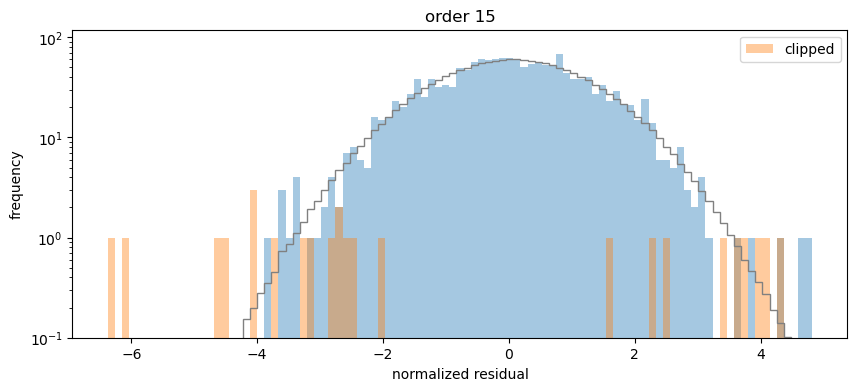

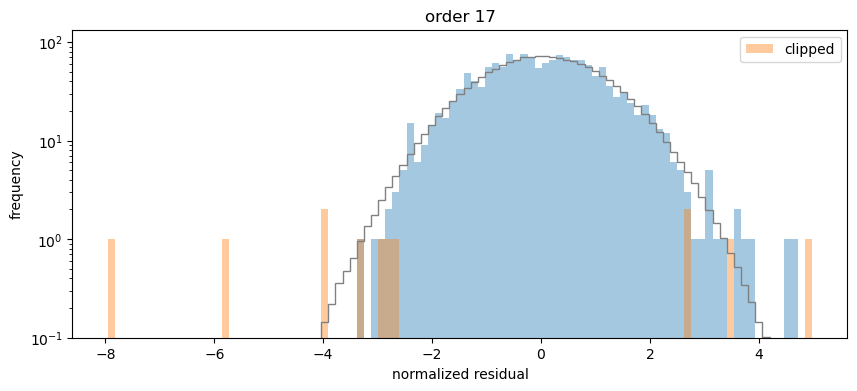

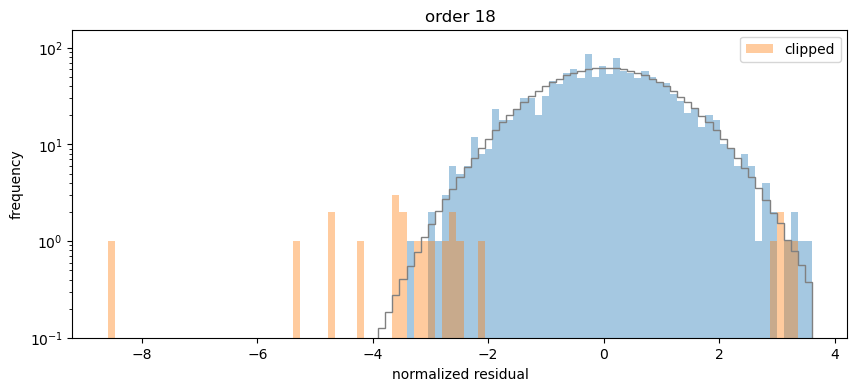

In [18]:
sf.check_residuals(p_fit)

In [19]:
p_fit = optim_svi(model, 1e-2, 2000, sf=sf, param_bounds=param_bounds, save_pred=False, p_initial=p_fit) 

  0%|          | 0/2000 [00:00<?, ?it/s]2024-11-10 23:03:38.117553: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 19.577889s

********************************
[Compiling module jit_body_fn] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
100%|██████████| 2000/2000 [02:05<00:00, 15.95it/s, init loss: -38528.2795, avg. loss [1901-2000]: -38631.6318]


In [20]:
p_fit

{'teff_scaled': Array(0.71193735, dtype=float64),
 'teff': Array(5991.78072725, dtype=float64),
 'logg_scaled': Array(0.64278793, dtype=float64),
 'logg': Array(4.28557586, dtype=float64),
 'feh_scaled': Array(0.51181884, dtype=float64),
 'feh': Array(-0.23227174, dtype=float64),
 'vsini_scaled': Array(0.29745335, dtype=float64),
 'vsini': Array(7.44897687, dtype=float64),
 'zeta_scaled': Array(0.47552028, dtype=float64),
 'zeta': Array(4.75520279, dtype=float64),
 'q1_scaled': Array(0.52083188, dtype=float64),
 'q1': Array(0.52083188, dtype=float64),
 'q2_scaled': Array(0.51614469, dtype=float64),
 'q2': Array(0.51614469, dtype=float64),
 'norm_scaled': Array([0.53246628, 0.53224481, 0.52557741, 0.5592465 , 0.59413082,
        0.5532127 , 0.56941777, 0.53314624, 0.52333367, 0.52948668],      dtype=float64),
 'norm': Array([1.01298651, 1.01289792, 1.01023096, 1.0236986 , 1.03765233,
        1.02128508, 1.02776711, 1.01325849, 1.00933347, 1.01179467],      dtype=float64),
 'slope_scaled

In [21]:
p_scaled = scale_pdic(p_fit, param_bounds)

In [22]:
keys_gp = ['lna', 'lnc', 'lnsigma']
for key in keys_gp:
    p_scaled[key] = p_fit[key]

In [23]:
p_scaled

{'teff_scaled': Array(0.71193735, dtype=float64),
 'logg_scaled': Array(0.64278793, dtype=float64),
 'feh_scaled': Array(0.51181884, dtype=float64),
 'vsini_scaled': Array(0.29745335, dtype=float64),
 'zeta_scaled': Array(0.47552028, dtype=float64),
 'q1_scaled': Array(0.52083188, dtype=float64),
 'q2_scaled': Array(0.51614469, dtype=float64),
 'norm_scaled': Array([0.53246628, 0.53224481, 0.52557741, 0.5592465 , 0.59413082,
        0.5532127 , 0.56941777, 0.53314624, 0.52333367, 0.52948668],      dtype=float64),
 'slope_scaled': Array([0.6284471 , 0.60385637, 0.61354565, 0.55296877, 0.67482346,
        0.67162833, 0.61122667, 0.63325678, 0.51777925, 0.55112857],      dtype=float64),
 'rv_scaled': Array([0.49675952, 0.50036277, 0.46840066, 0.49945466, 0.5034089 ,
        0.51585901, 0.5117616 , 0.46757542, 0.50261252, 0.48036855],      dtype=float64),
 'alpha_scaled': Array(0.09392153, dtype=float64),
 'lna': Array(-4.15298287, dtype=float64),
 'lnc': Array(-0.28285472, dtype=float64),

In [24]:
print ()
#kernel = numpyro.infer.NUTS(model, target_accept_prob=0.90, init_strategy=init_to_value(values=p_scaled), dense_mass=True, regularize_mass_matrix=False)
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.90, init_strategy=init_to_value(values=p_scaled), dense_mass=True, regularize_mass_matrix=True)
#kernel = numpyro.infer.NUTS(model, target_accept_prob=0.90, init_strategy=init_to_value(values=p_scaled), dense_mass=True, regularize_mass_matrix=False, inverse_mass_matrix=covariance_matrix)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=500)

In [25]:
# acc=0.9: ~7min for order=[8,9], ~11min for order=[8,9,10], 30min for [7,8,9,10,11]
print ("# running HMC...")
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sf, param_bounds, physical_logg_max=True, empirical_vmacro=False)
mcmc.print_summary()
smp = mcmc.get_samples()

# running HMC...


  0%|          | 0/1000 [00:00<?, ?it/s]2024-11-10 23:06:09.254871: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 23.480103s

********************************
[Compiling module jit__body_fn] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
sample: 100%|██████████| 1000/1000 [36:06<00:00,  2.17s/it, 31 steps of size 2.19e-01. acc. prob=0.94]  



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_scaled      0.07      0.04      0.06      0.00      0.12    350.25      1.00
     feh_scaled      0.53      0.02      0.53      0.50      0.57     21.51      1.05
            lna     -4.14      0.02     -4.14     -4.17     -4.11    575.07      1.00
            lnc     -0.27      0.04     -0.27     -0.33     -0.21    598.80      1.00
        lnsigma     -8.91      0.69     -8.96    -10.00     -7.93    462.95      1.00
           logg      4.37      0.10      4.35      4.26      4.61     13.41      1.10
 norm_scaled[0]      0.53      0.00      0.53      0.52      0.54    549.30      1.00
 norm_scaled[1]      0.53      0.00      0.53      0.53      0.54    584.98      1.00
 norm_scaled[2]      0.53      0.00      0.53      0.52      0.53    767.18      1.00
 norm_scaled[3]      0.56      0.00      0.56      0.55      0.57    548.95      1.00
 norm_scaled[4]      0.59      0.00      0.59      0.

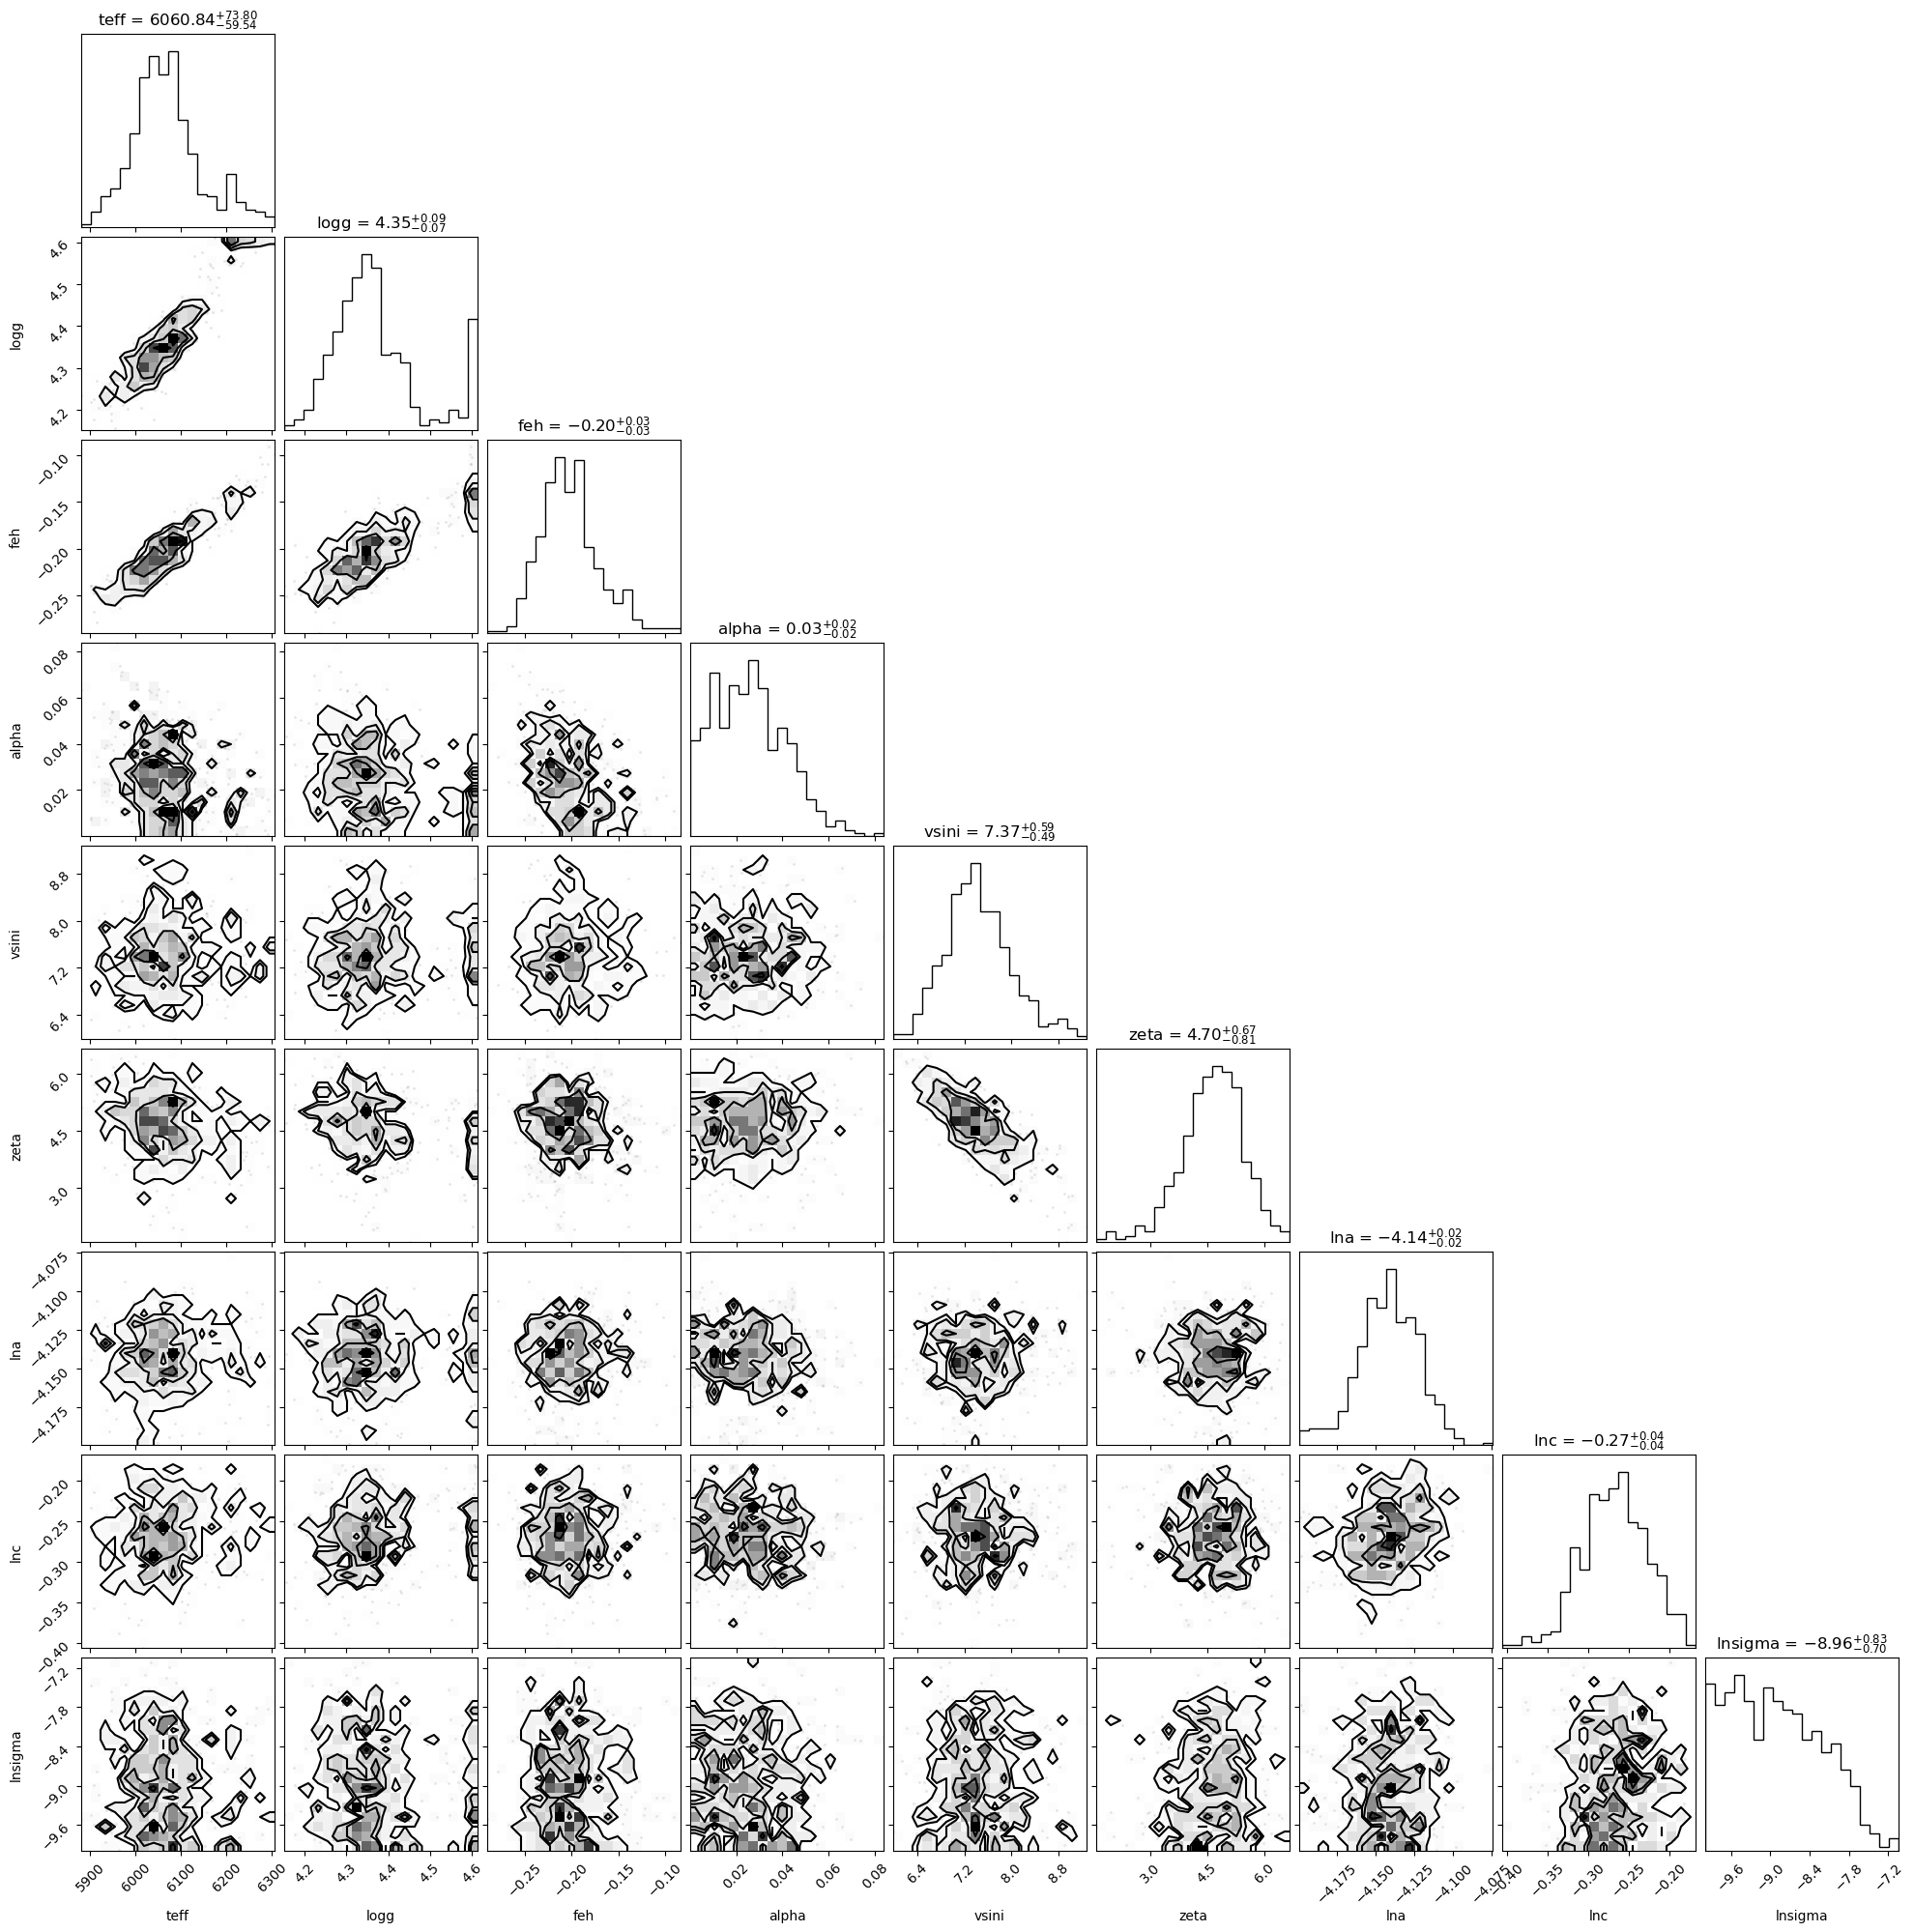

In [26]:
# turbo3500 all
names = ['teff', 'logg', 'feh', 'alpha', 'vsini', 'zeta', 'lna', 'lnc', 'lnsigma']
hyper = np.array(pd.DataFrame(data=dict(zip(names, [smp[k] for k in names]))))
fig = corner.corner(hyper, labels=names, show_titles="%.2f")

In [30]:
# acc=0.9: ~7min for order=[8,9], ~11min for order=[8,9,10], 30min for [7,8,9,10,11]
print ("# running HMC...")
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sf, param_bounds, physical_logg_max=True, empirical_vmacro=False)
mcmc.print_summary()
smp = mcmc.get_samples()

# running HMC...


  0%|          | 0/1000 [00:00<?, ?it/s]2024-11-06 09:40:14.570911: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 25.516312s

********************************
[Compiling module jit__body_fn] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
sample: 100%|██████████| 1000/1000 [1:16:28<00:00,  4.59s/it, 31 steps of size 1.57e-01. acc. prob=0.97] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_scaled      0.01      0.01      0.01      0.00      0.03    917.86      1.00
     feh_scaled      0.73      0.01      0.73      0.71      0.75    452.28      1.00
            lna     -4.27      0.02     -4.27     -4.31     -4.23    899.89      1.00
            lnc      0.04      0.06      0.03     -0.05      0.13    793.69      1.00
        lnsigma     -8.88      0.71     -8.93     -9.99     -7.88    475.34      1.00
           logg      4.54      0.06      4.54      4.45      4.62    283.06      1.00
 norm_scaled[0]      0.54      0.00      0.54      0.53      0.54    682.99      1.00
 norm_scaled[1]      0.53      0.00      0.53      0.53      0.54   1019.25      1.00
 norm_scaled[2]      0.53      0.00      0.53      0.52      0.54   1334.90      1.00
 norm_scaled[3]      0.56      0.00      0.56      0.55      0.57    723.45      1.00
 norm_scaled[4]      0.59      0.00      0.59      0.

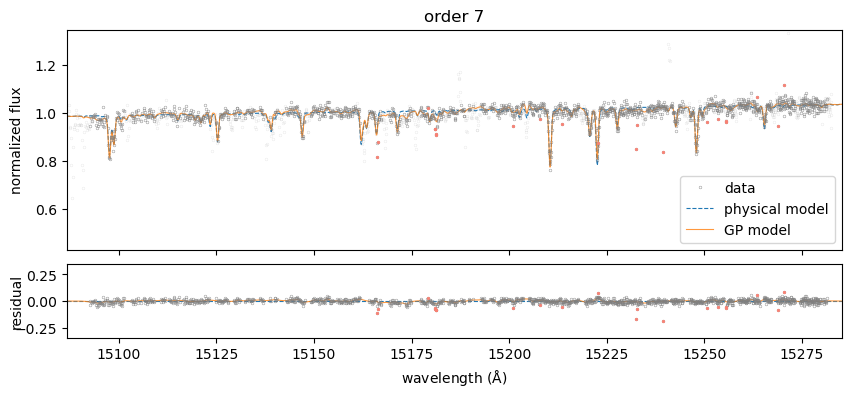

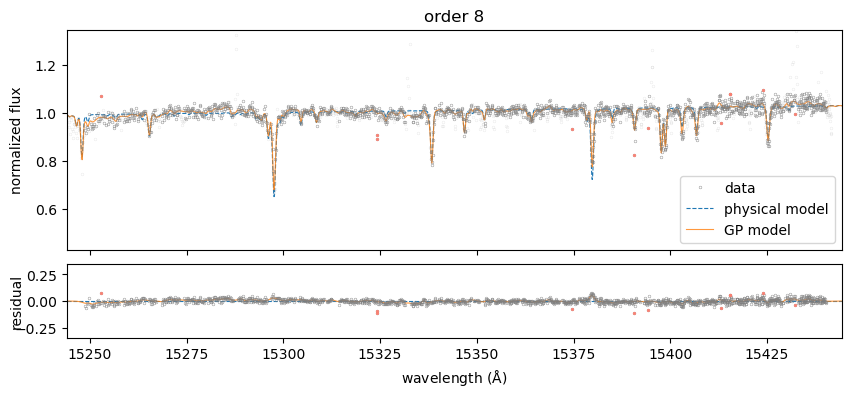

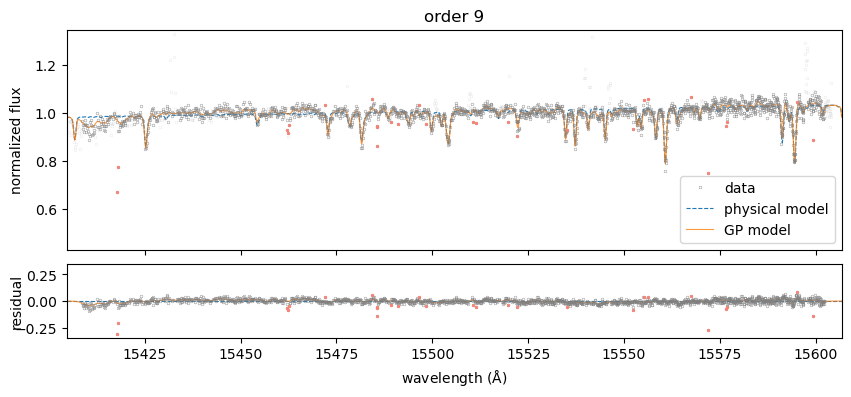

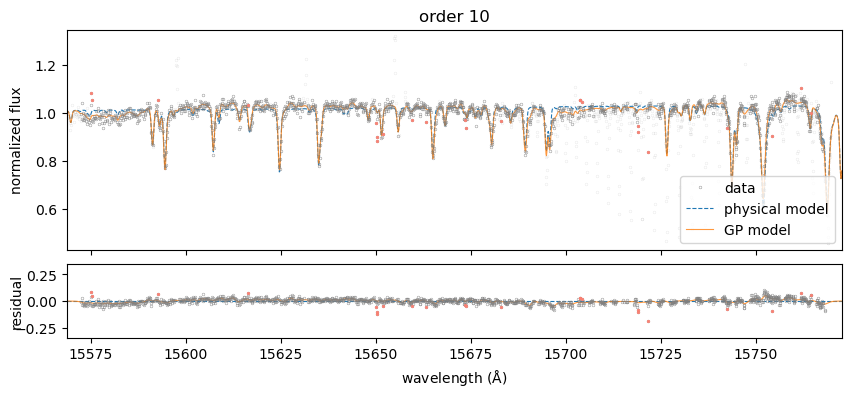

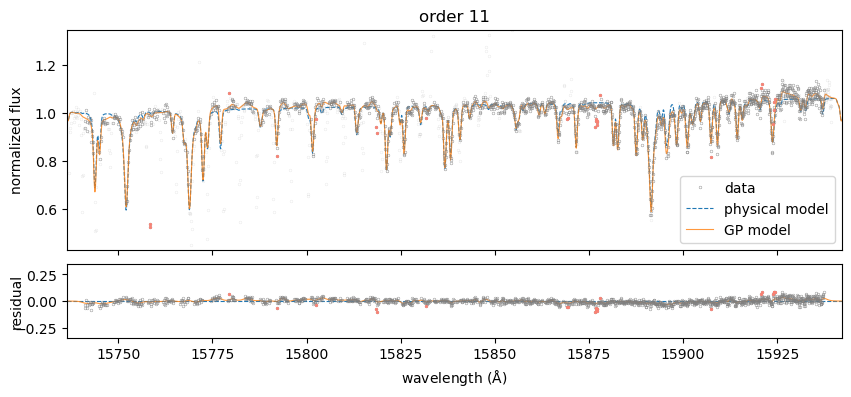

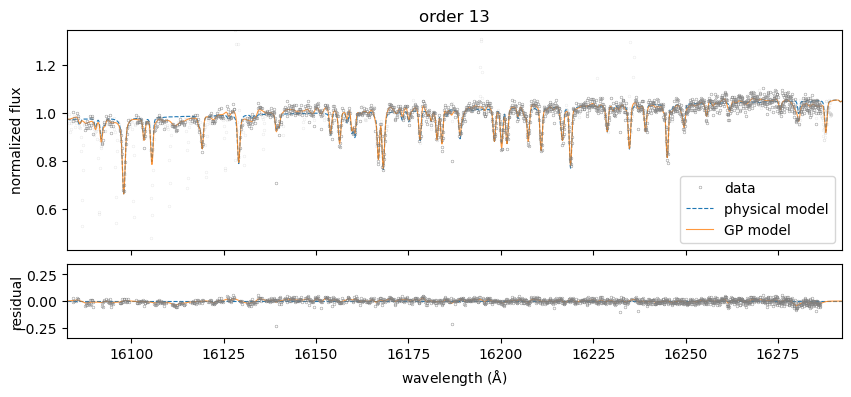

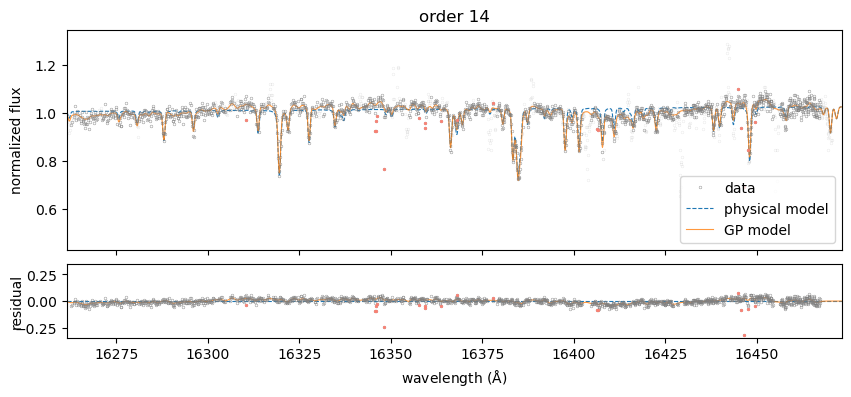

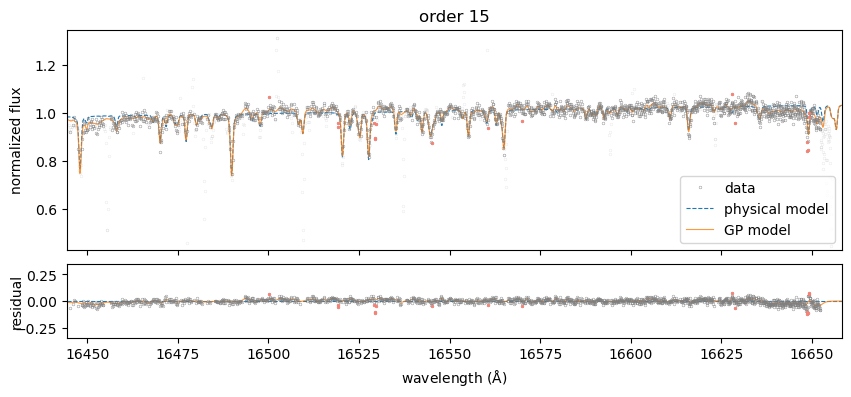

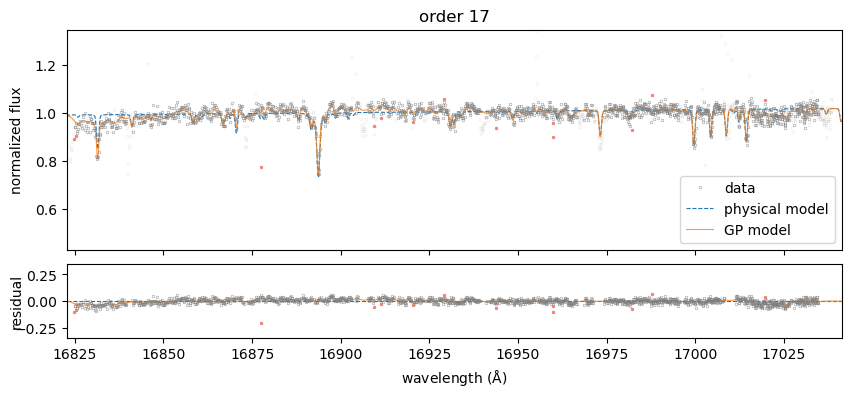

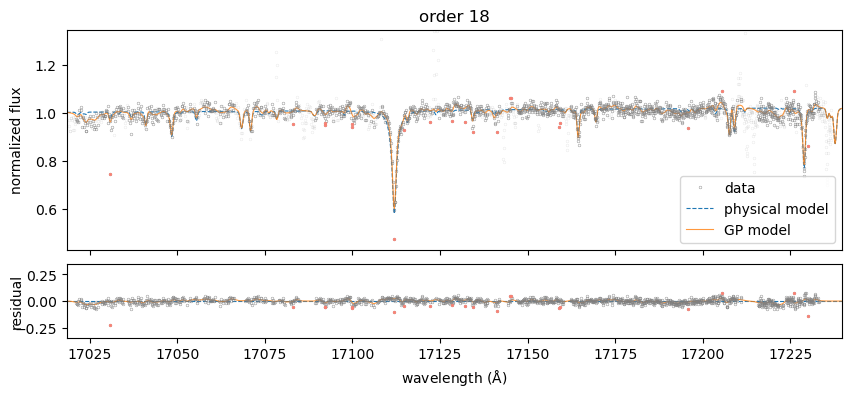

In [31]:
ms, mgps = get_mean_models(smp, sf)
sf.plot_models(ms, mgps)

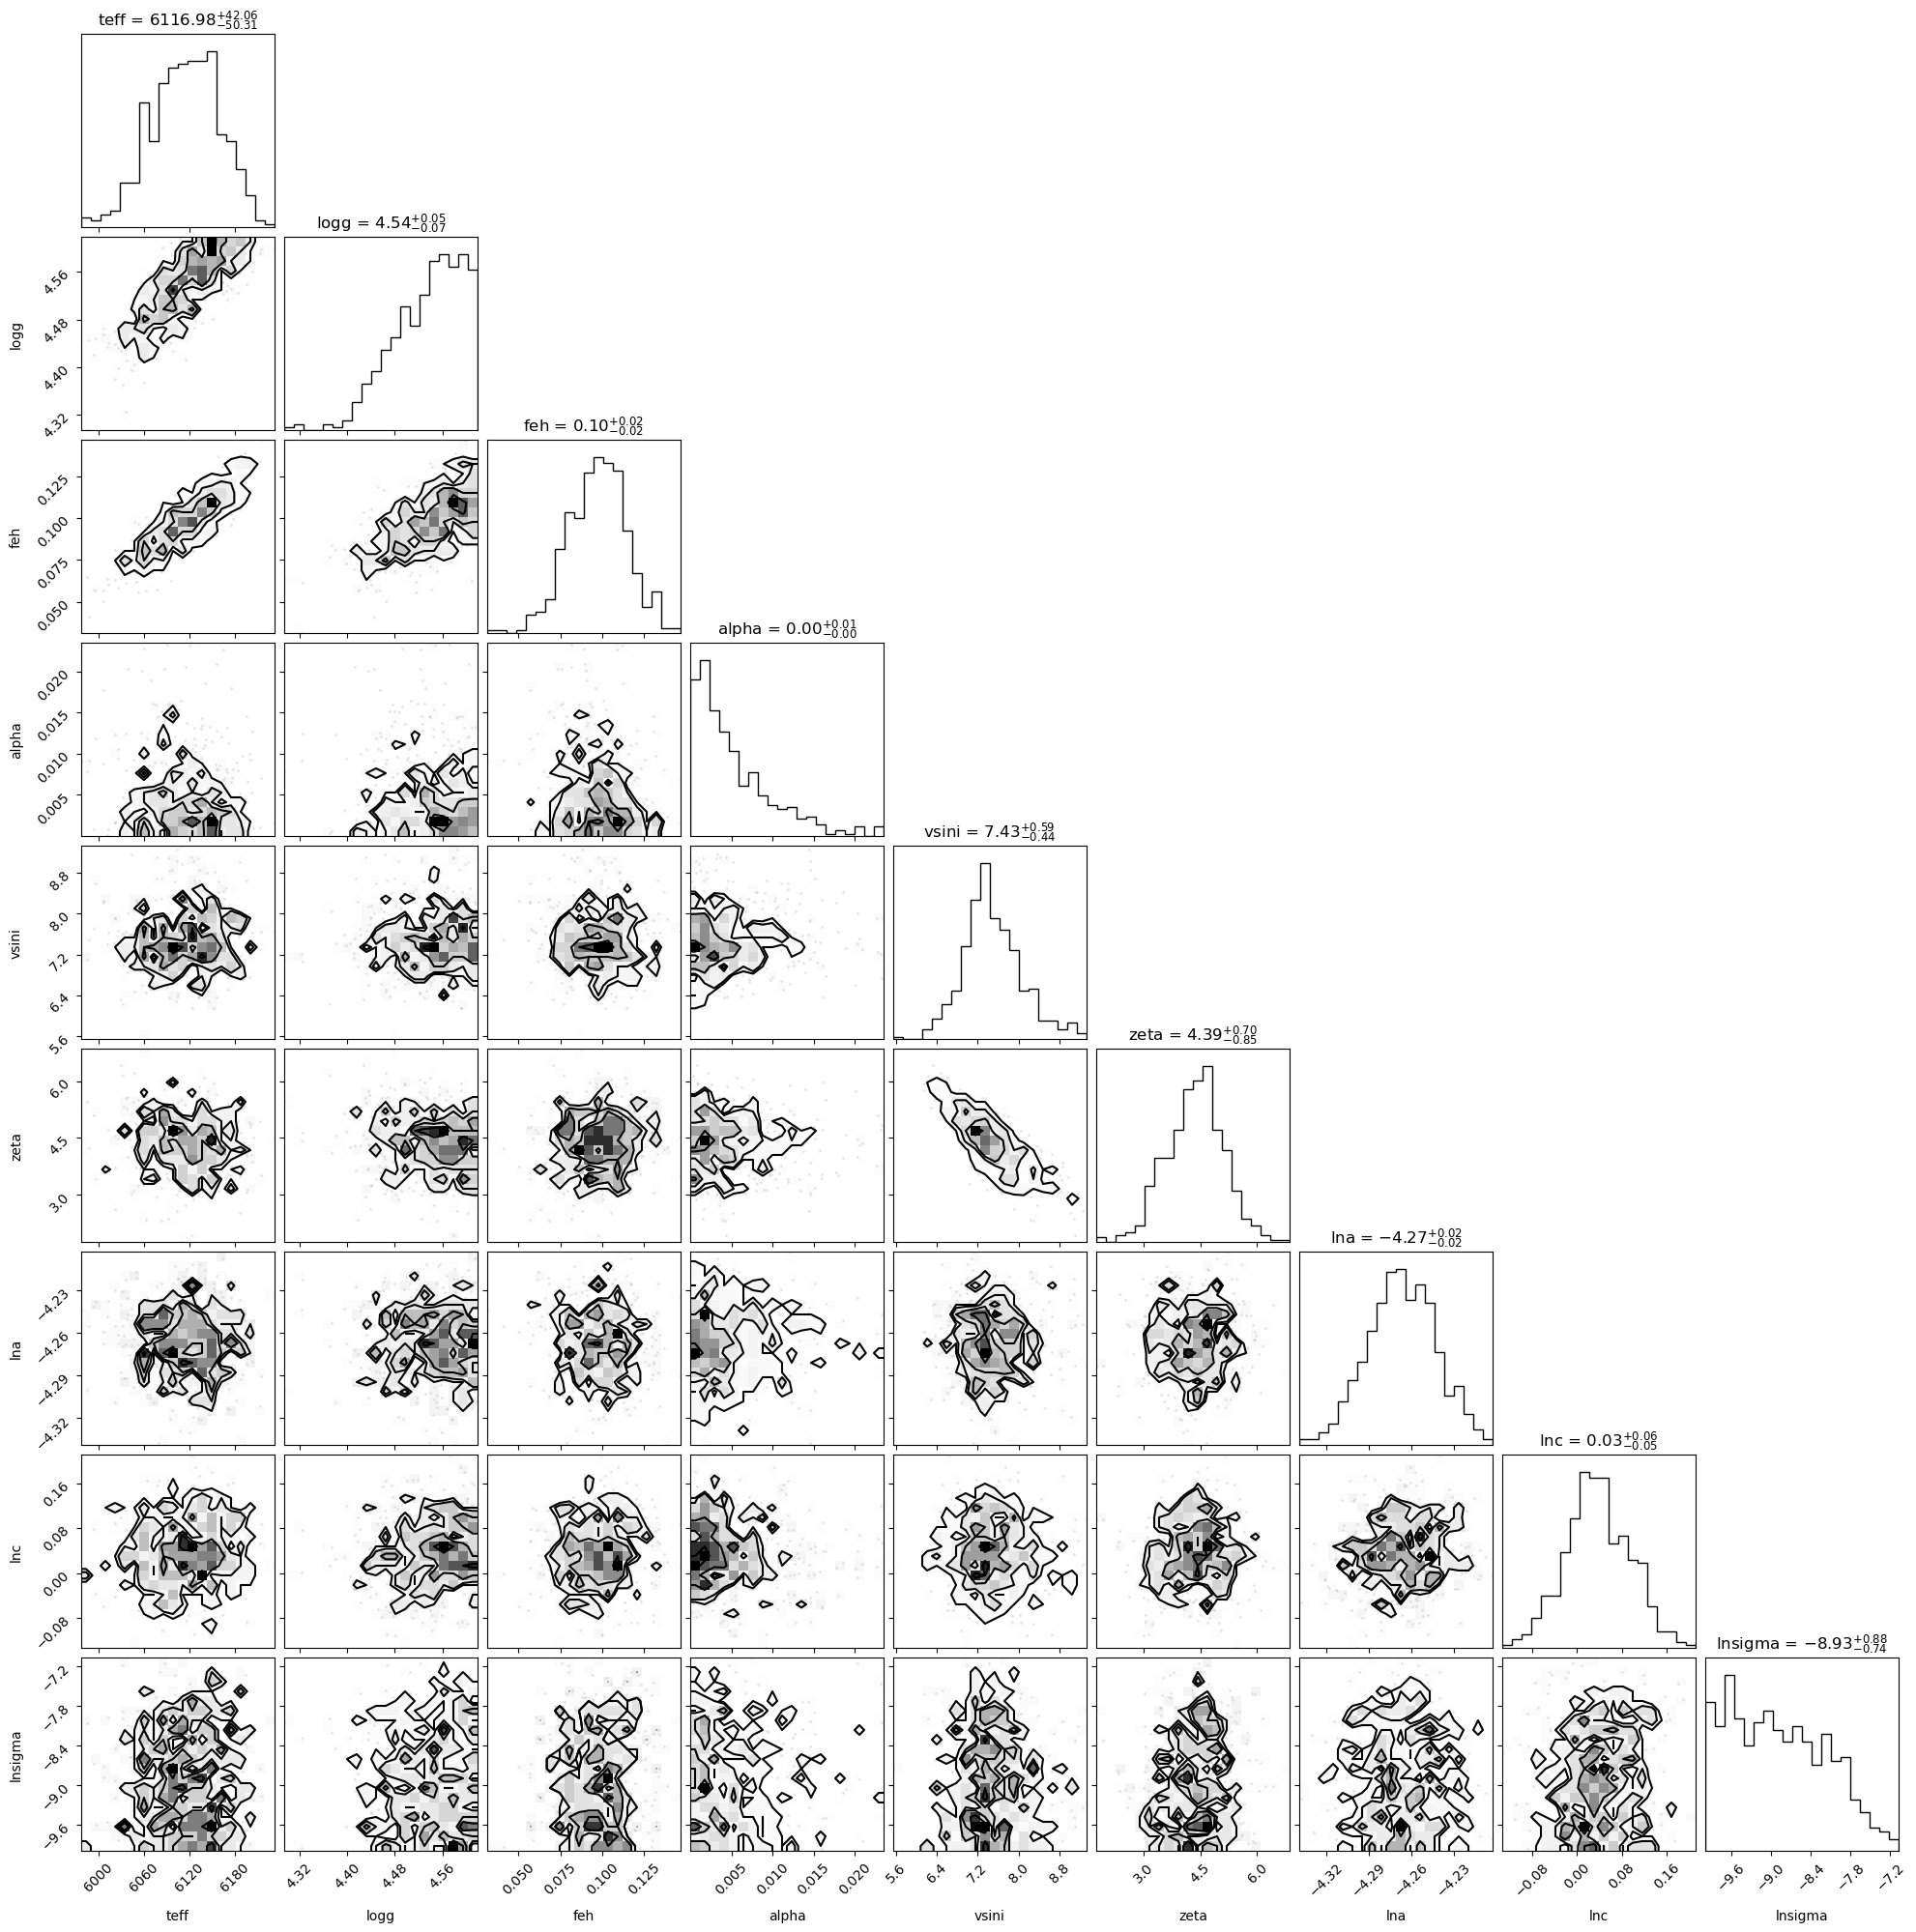

In [32]:
# coelho all
names = ['teff', 'logg', 'feh', 'alpha', 'vsini', 'zeta', 'lna', 'lnc', 'lnsigma']
hyper = np.array(pd.DataFrame(data=dict(zip(names, [smp[k] for k in names]))))
fig = corner.corner(hyper, labels=names, show_titles="%.2f")

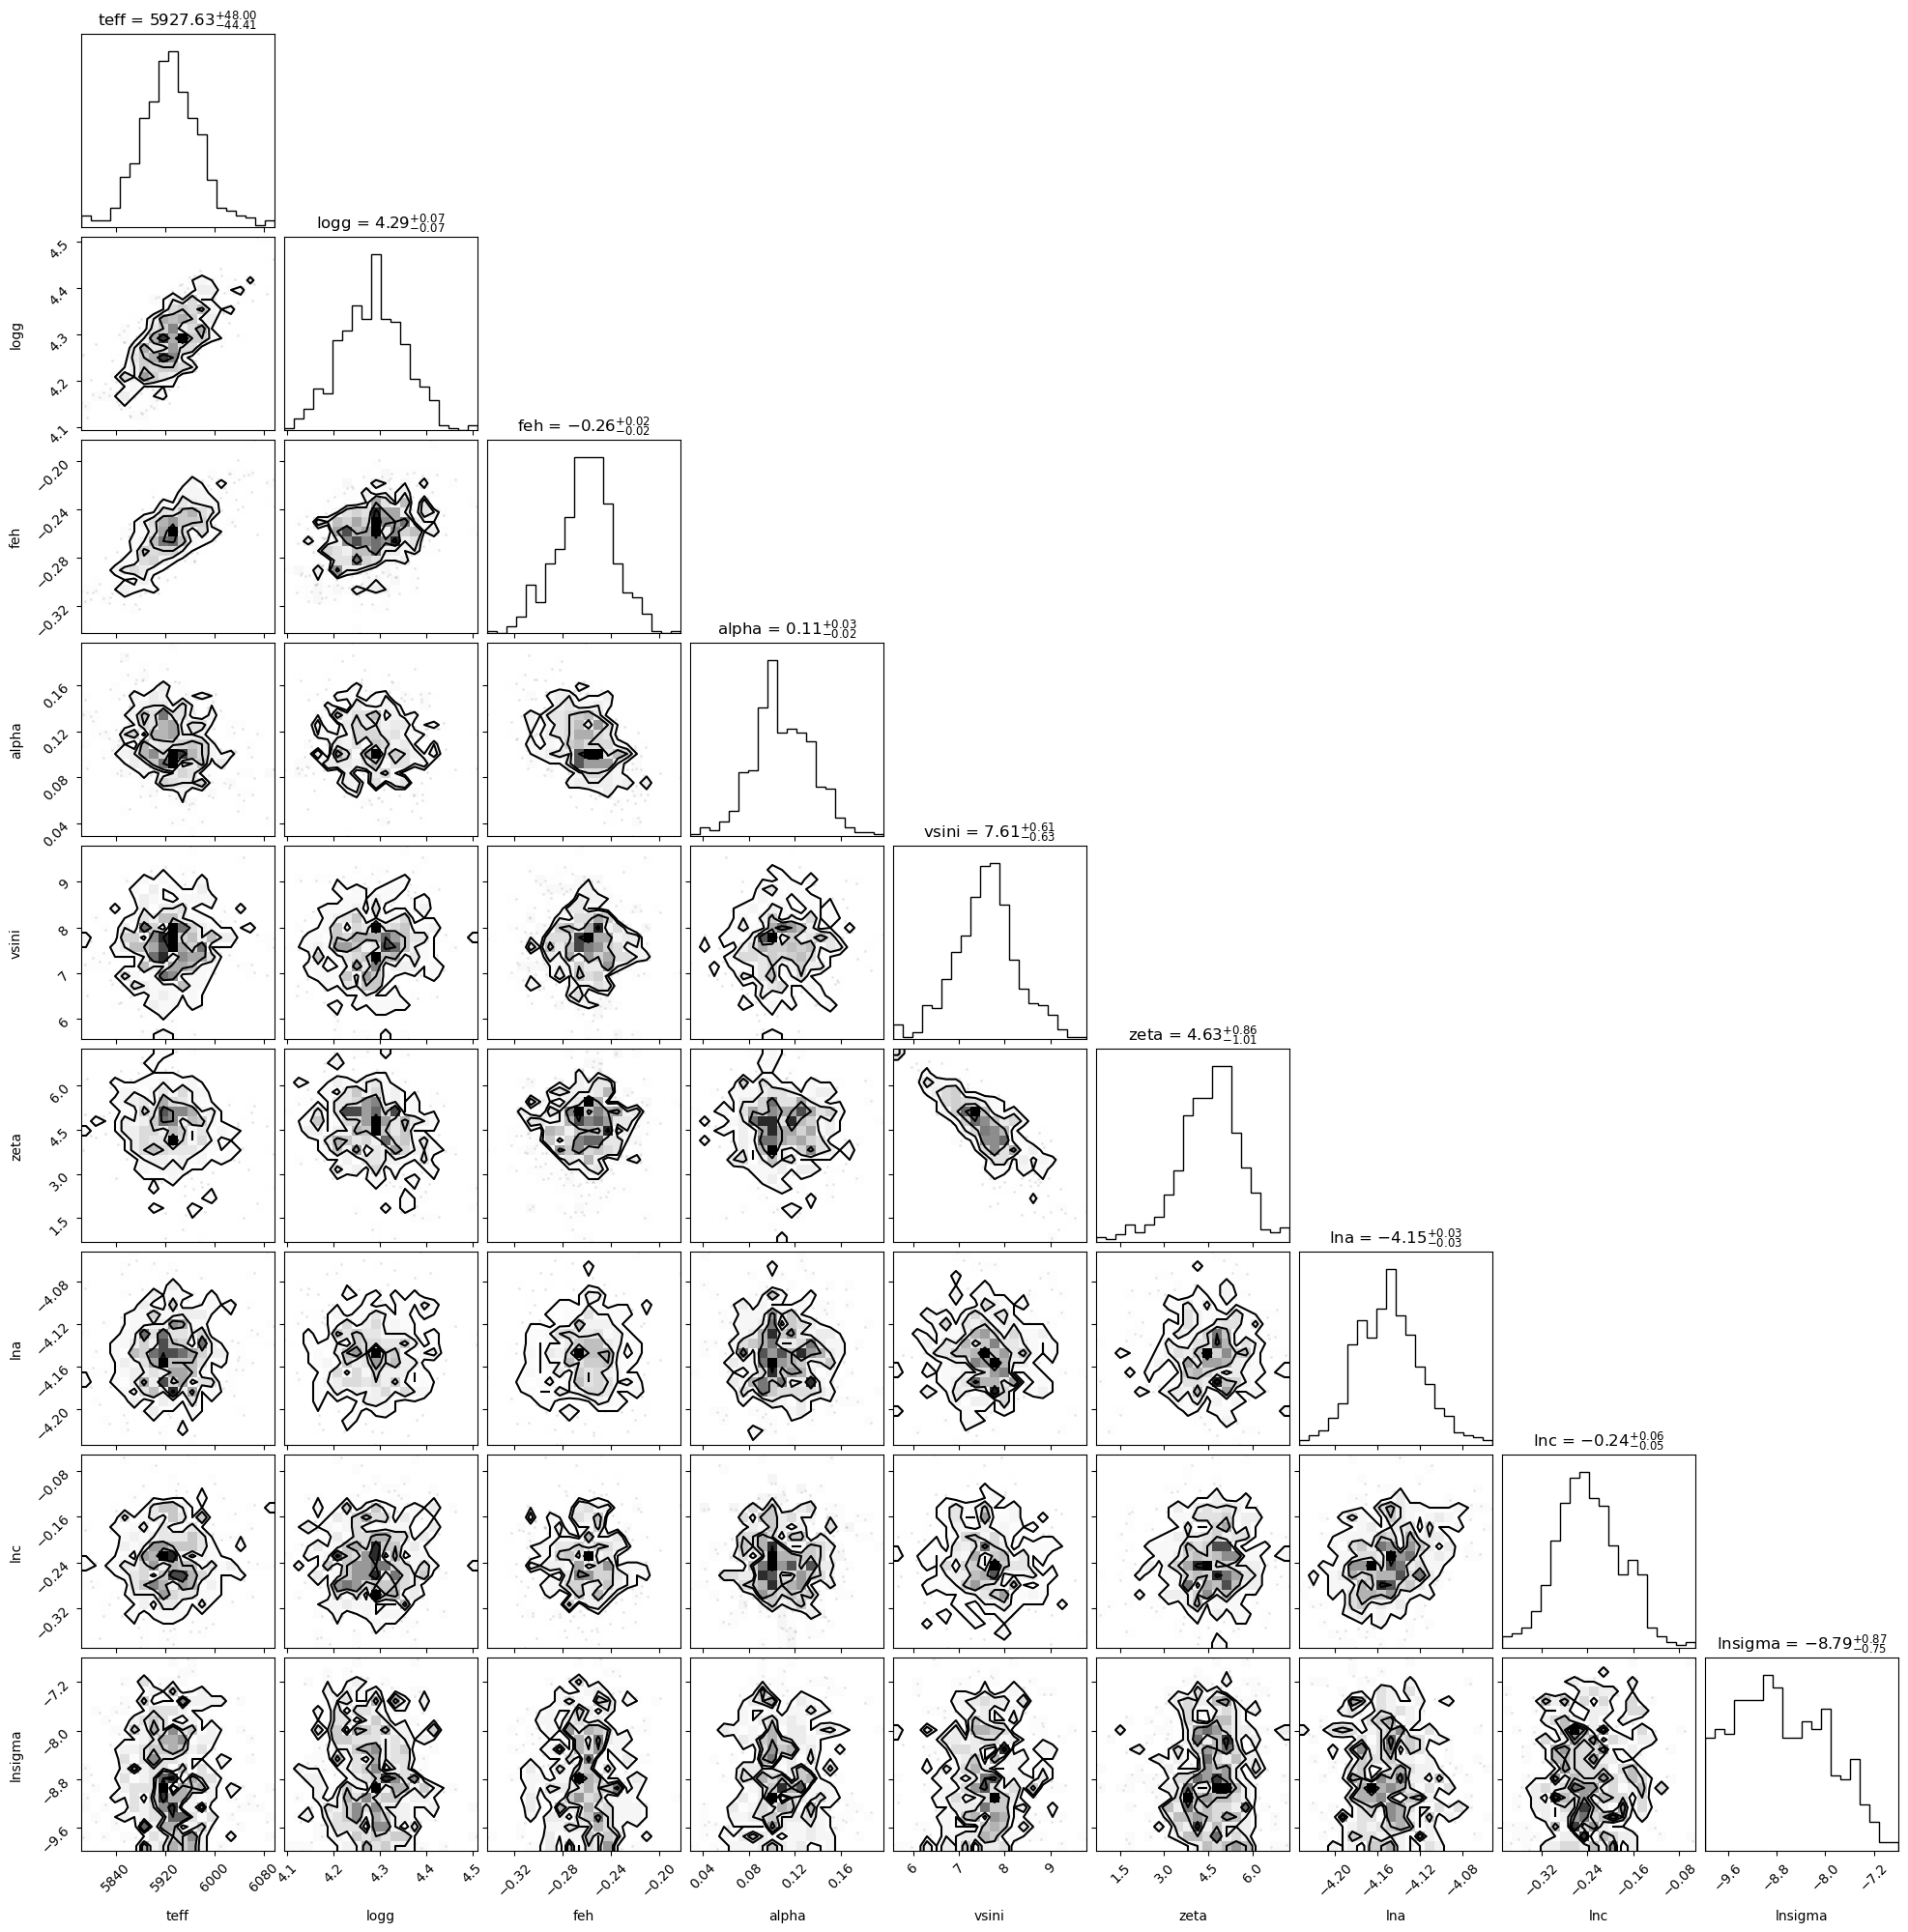

In [48]:
names = ['teff', 'logg', 'feh', 'alpha', 'vsini', 'zeta', 'lna', 'lnc', 'lnsigma']
hyper = np.array(pd.DataFrame(data=dict(zip(names, [smp[k] for k in names]))))
fig = corner.corner(hyper, labels=names, show_titles="%.2f")

In [228]:
sample_keys = ['teff', 'feh', 'alpha', 'vsini', 'zeta', 'rv']

In [229]:
infomat = information(sf, p_fit, sample_keys)

In [230]:
infomat_scaled = scaled_information(sf, p_fit, param_bounds, sample_keys)

In [231]:
cov_scaled = jnp.linalg.inv(infomat_scaled)

In [232]:
p_fit_scaled = scale_pdic(p_fit, param_bounds)

/var/folders/68/h6r0kcq50914zzw8n_70l69c0000gn/T/ipykernel_6451/3131059186.py:16: RuntimeWarning: invalid value encountered in divide
  pdic_scaled[key+"_scaled"] = (pdic[key] - param_bounds[key][0]) / (param_bounds[key][1] - param_bounds[key][0])


In [234]:
p_fit_scaled

{'teff_scaled': Array(0.67042482, dtype=float64),
 'logg_scaled': Array(0.73334721, dtype=float64),
 'feh_scaled': Array(0.45566188, dtype=float64),
 'alpha_scaled': Array(0.5868779, dtype=float64),
 'vsini_scaled': Array(0.43226411, dtype=float64),
 'zeta_scaled': Array(0.33356524, dtype=float64),
 'q1_scaled': Array(0.49350203, dtype=float64),
 'q2_scaled': Array(0.49101512, dtype=float64),
 'norm_scaled': Array([0.53462783, 0.52670026], dtype=float64),
 'slope_scaled': Array([0.6063896 , 0.61202376], dtype=float64),
 'rv_scaled': Array([0.57051186, 0.48053325], dtype=float64),
 'wavres_scaled': array([nan, nan])}

In [235]:
dense_mass_keys = [tuple([key+"_scaled" for key in sample_keys])]#, tuple(["lna"]), tuple(["lnc"]), tuple(["lnsigma"])]
inv_mass_init = {dense_mass_keys[0]: cov_scaled}#, dense_mass_keys[1]: jnp.array([0.1**2]), dense_mass_keys[2]: jnp.array([0.1**2]), dense_mass_keys[3]: jnp.array([1.**2])}

In [236]:
dense_mass_keys

[('teff_scaled',
  'feh_scaled',
  'alpha_scaled',
  'vsini_scaled',
  'zeta_scaled',
  'rv_scaled')]

In [239]:
print ()
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.90, init_strategy=init_to_value(values=p_fit_scaled), dense_mass=dense_mass_keys, 
                        inverse_mass_matrix=inv_mass_init, regularize_mass_matrix=False, adapt_mass_matrix=False)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=500)

In [240]:
print ("# running HMC...")
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sf, param_bounds, physical_logg_max=True, empirical_vmacro=False)
mcmc.print_summary()
smp = mcmc.get_samples()

# running HMC...


warmup:   2%|▏         | 18/1000 [01:33<1:24:51,  5.18s/it, 511 steps of size 1.22e-02. acc. prob=0.78] 


KeyboardInterrupt: 

In [37]:
p_scaled

{'teff_scaled': Array(0.67043468, dtype=float64),
 'logg_scaled': Array(0.73345849, dtype=float64),
 'feh_scaled': Array(0.45567101, dtype=float64),
 'alpha_scaled': Array(0.5867684, dtype=float64),
 'vsini_scaled': Array(0.43227767, dtype=float64),
 'zeta_scaled': Array(0.33359821, dtype=float64),
 'q1_scaled': Array(0.4932433, dtype=float64),
 'q2_scaled': Array(0.49097092, dtype=float64),
 'norm_scaled': Array([0.53462684, 0.5266989 ], dtype=float64),
 'slope_scaled': Array([0.60638751, 0.61204119], dtype=float64),
 'rv_scaled': Array([0.5705793 , 0.48046966], dtype=float64)}

# running HMC...


sample: 100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s, 31 steps of size 1.67e-01. acc. prob=0.96]  



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_scaled      0.59      0.13      0.60      0.35      0.79    666.87      1.00
     feh_scaled      0.46      0.03      0.46      0.41      0.50    609.90      1.00
            lna     -4.30      0.05     -4.30     -4.38     -4.22    744.28      1.00
            lnc     -0.21      0.11     -0.21     -0.39     -0.03    482.49      1.00
        lnsigma     -8.57      0.91     -8.64    -10.00     -7.26    319.57      1.00
           logg      4.46      0.14      4.48      4.27      4.66    384.34      1.00
 norm_scaled[0]      0.53      0.00      0.53      0.53      0.54    450.17      1.01
 norm_scaled[1]      0.53      0.00      0.53      0.52      0.53    638.86      1.00
      q1_scaled      0.51      0.29      0.50      0.10      1.00    572.11      1.01
      q2_scaled      0.49      0.28      0.50      0.00      0.87    513.74      1.00
   rv_scaled[0]      0.57      0.02      0.57      0.

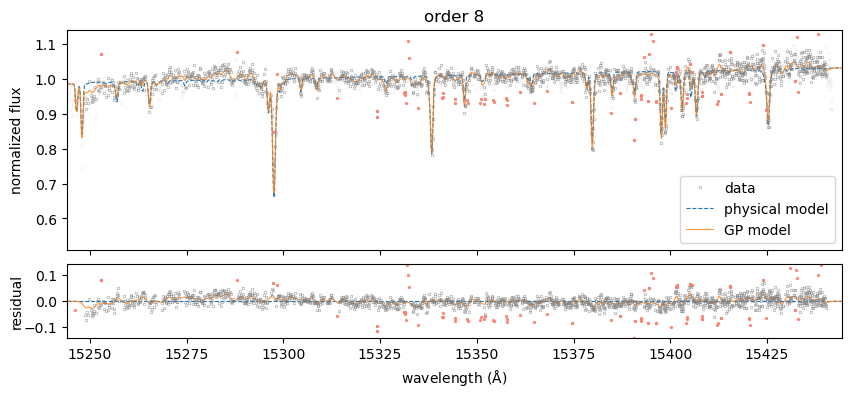

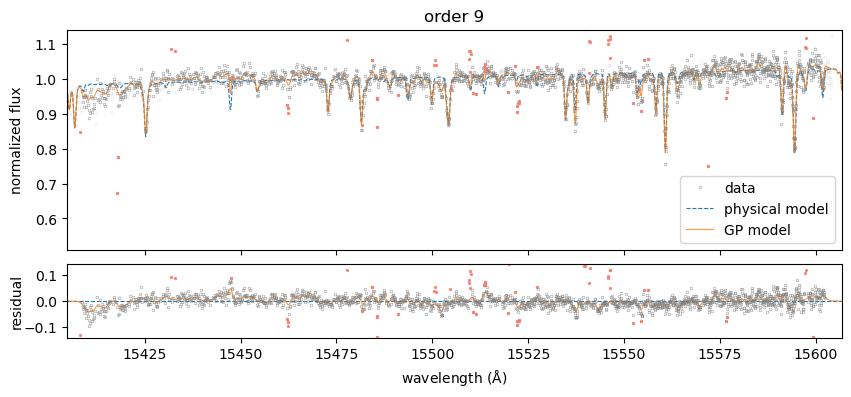

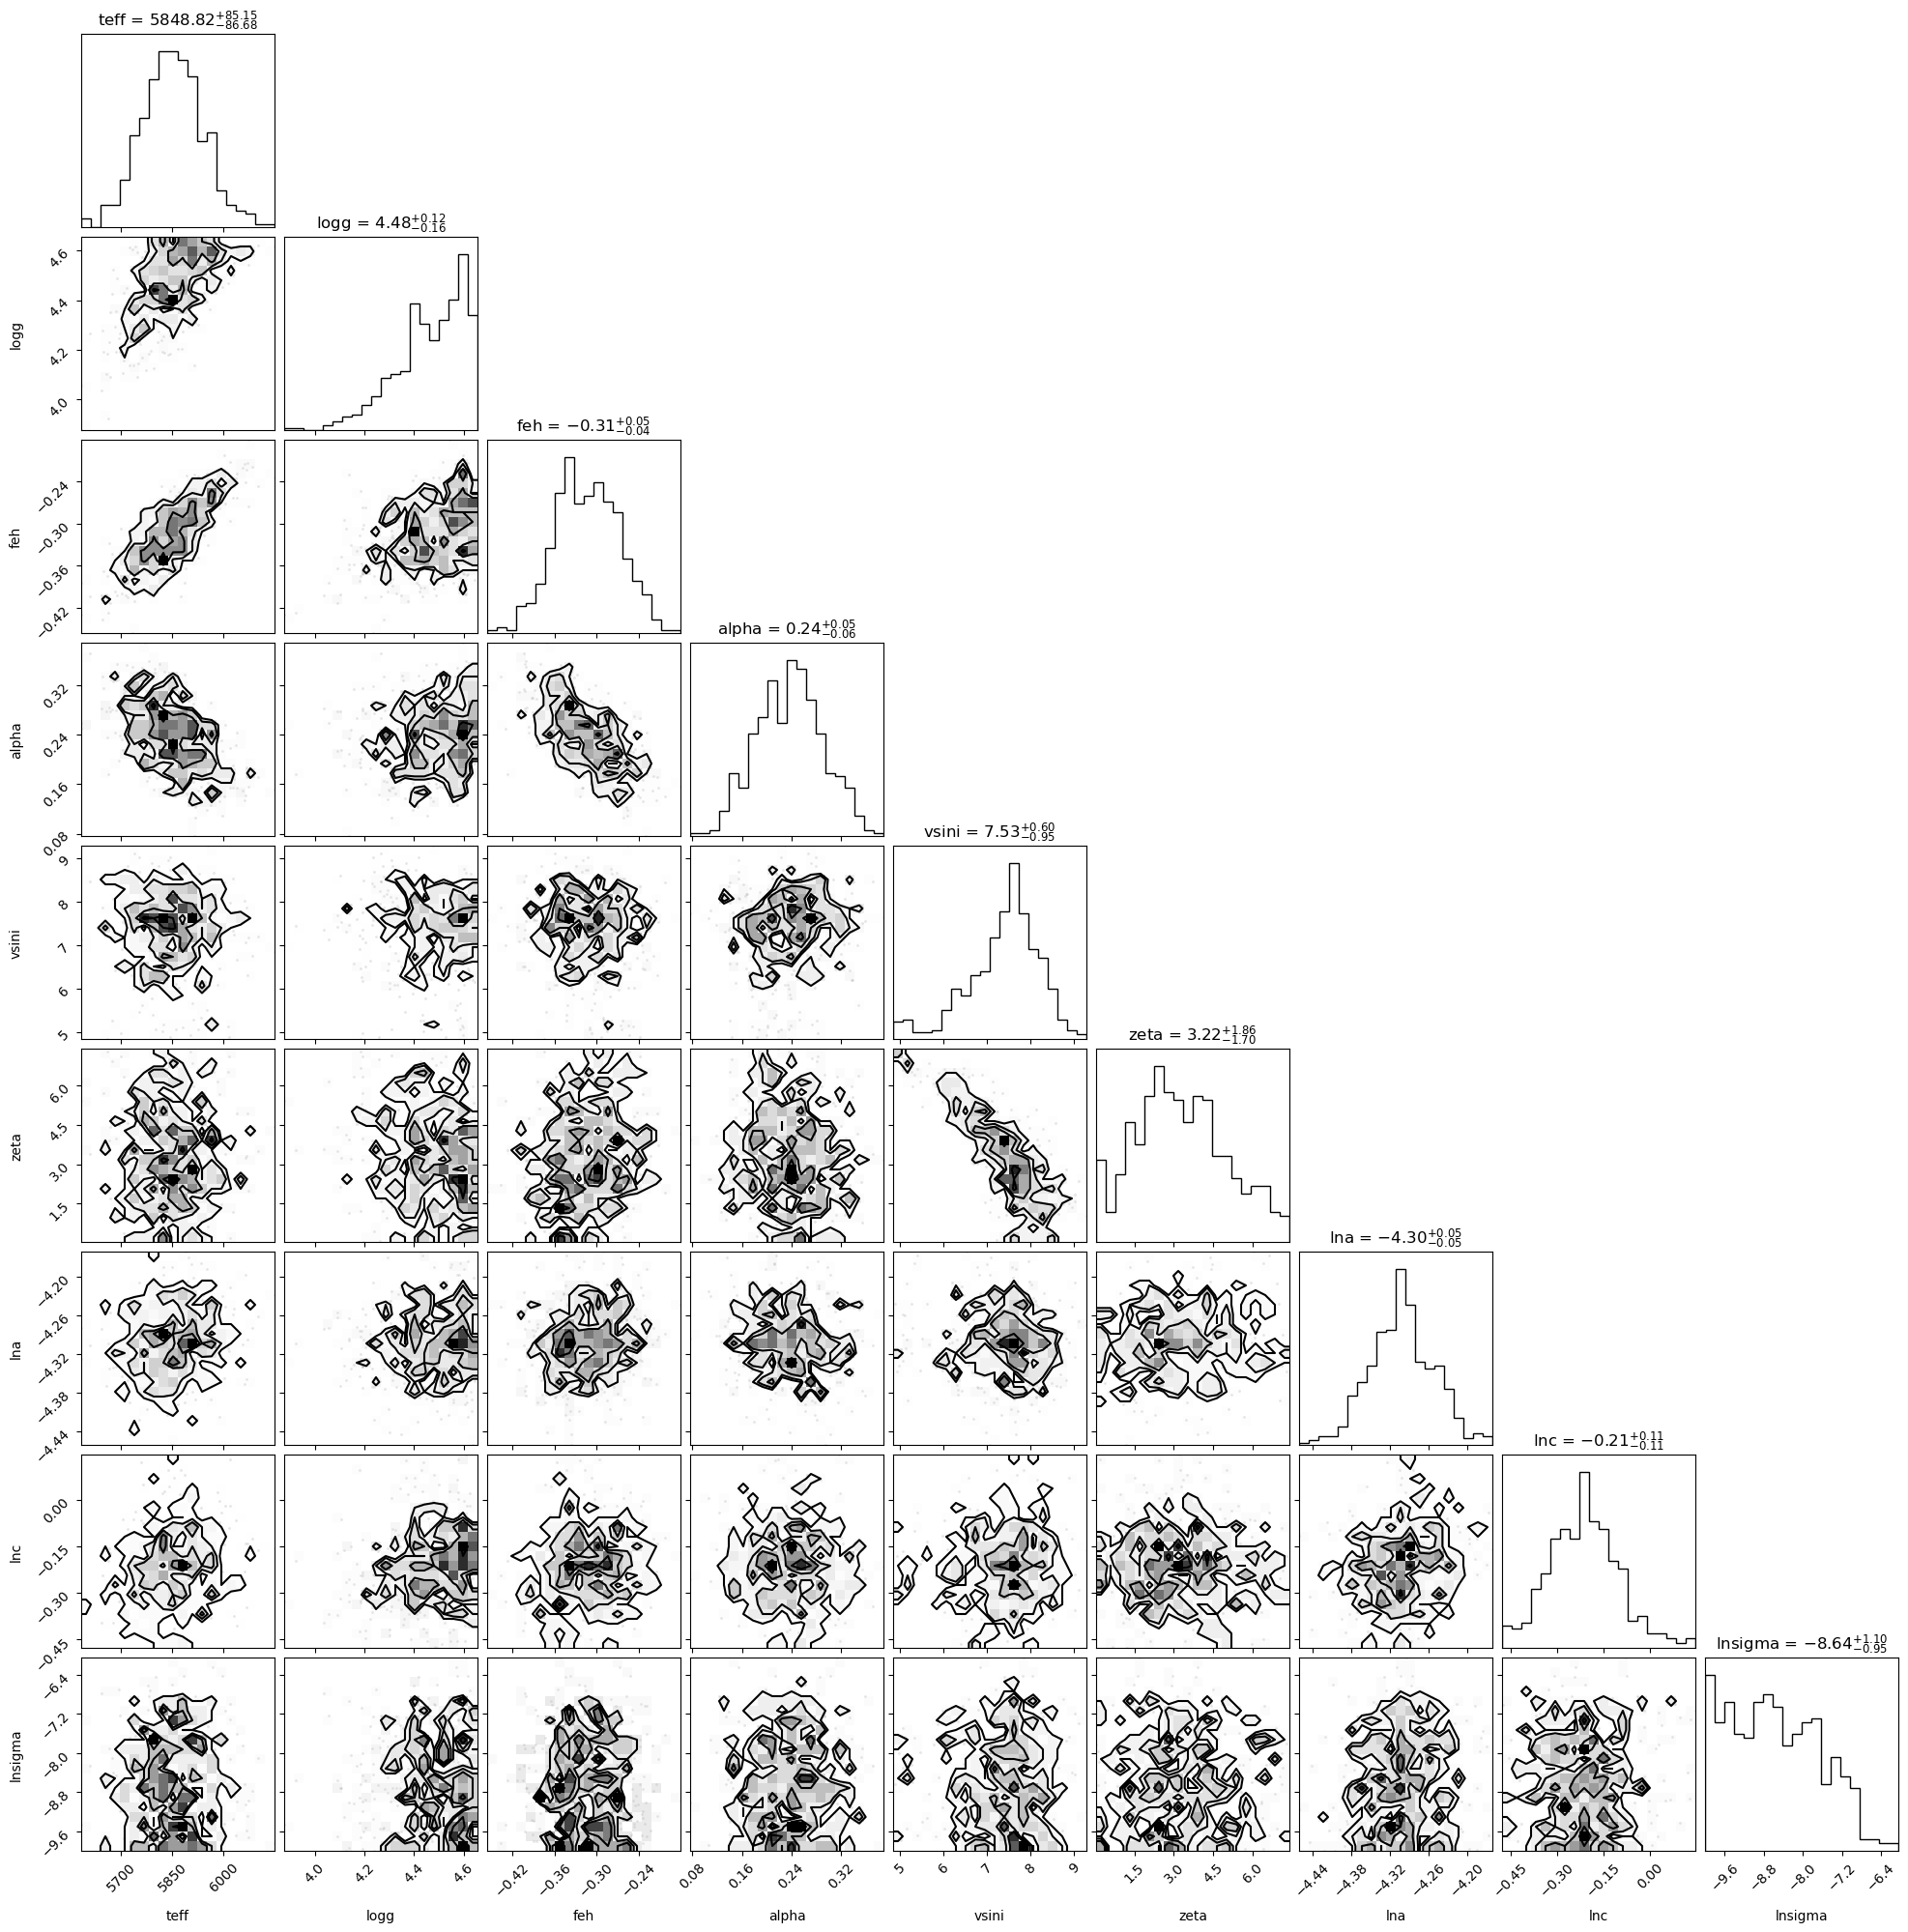